<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/dev_1.14.0/Navier_stokes_equations_with_singularity_Navier_Stokes_equation_solved_IBM_DARPA_FinanceLLMsBackRL_adversarial_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link code source](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb#scrollTo=qzqgPBUuForj)



```
you can use this notebook, if you want to run this code with video data absolutely do not change just follow  the procedure for
processing video data in this notebook link.
```



**FinanceLLMsBackRL**

In [ ]:
!pip uninstall -y tensorflow && pip install tensorflow-cpu

In [ ]:
!pip3 install --upgrade pymc

In [4]:
import pymc as pm

In [ ]:
!pip install --upgrade gensim

In [ ]:
!pip3 install matplotlib IPython moviepy mpi4py
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation

In [ ]:
'''
install library which is not already installed
'''
!pip install torch torchvision
!pip install transformers
!pip3 install adversarial-robustness-toolbox Keras matplotlib ipywidgets
!pip install tensorflow==2.15


In [5]:
# @title



import logging
import numpy as np
logging.basicConfig(level=logging.INFO)  # Set the desired logging level
import librosa

class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.01,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.01,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion

In [6]:

import pymc as pm
from IPython.display import Audio, Image
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

import matplotlib.pyplot as plt
import torch
import torchvision
import transformers

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

# ESC-50: Dataset for Environmental Sound Classification

[link datasets Hugging Face](https://huggingface.co/blog/audio-datasets)

In [7]:
#!pip install datasets

# install datasets
%%capture
!pip install datasets==1.18.3
from datasets import load_dataset, Audio

In [ ]:
fleurs = load_dataset("google/fleurs", "all", split="validation")
fleurs

In [ ]:
minds14 = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds14

In [ ]:
# Instead of trying to load with "all", choose one of the available configurations:
librispeech = load_dataset("librispeech_asr", "clean")  # Or "other"

#If you need both "clean" and "other", you need to load them separately and combine them:
from datasets import concatenate_datasets

clean_dataset = load_dataset("librispeech_asr", "clean")
other_dataset = load_dataset("librispeech_asr", "other")

# Assuming both datasets have the same features, you can concatenate them:
librispeech = concatenate_datasets([clean_dataset["train"], other_dataset["train"]])


In [ ]:
vctk = load_dataset("CSTR-Edinburgh/vctk", split="train[:10]")
vctk

In [8]:
# Let's import the library. We typically only need at most two methods:
from datasets import list_datasets, load_dataset
from pprint import pprint

from tqdm.notebook import tqdm
import os; import psutil; import timeit

#loading the dataset from 'datasets' library
timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
import numpy as np
#!pip install phiflow #install phiflow
#!pip install geomstats #install geomstats
from collections import deque

In [10]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

In [11]:
# @title



from IPython import display
import tensorflow as tf
import librosa
import numpy as np
import os

# Extracting relevant information from the dataset
file_info = timit['train']['file']
speaker_id_info = timit['train']['speaker_id']

# Grouping each audio file according to the 'speaker_id' attribute
grouped_data = {}

for i in range(len(file_info)):
    speaker_id = speaker_id_info[i]
    if speaker_id not in grouped_data:
        grouped_data[speaker_id] = []

    file_data = {
        'file': file_info[i],
        'speaker_id': speaker_id_info[i],
    }

    grouped_data[speaker_id].append(file_data)

# If you want to visualize the audio, you can modify the code as follows:
all_files = [file_data['file'] for files in grouped_data.values() for file_data in files]

# Shuffle the files
filenames = tf.random.shuffle(all_files).numpy()
example_files = filenames[:2000]

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)


x_audio, y_audio = get_audio_clips_and_labels(example_files)

# Displaying information about the first few audio clips
for i in range(3):
    print('Speaker ID Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Speaker ID Label: MCXM0


Speaker ID Label: FAEM0


Speaker ID Label: MHBS0









## Backdoor attack Speech : FinanceLLMsBackRL

In [ ]:
!pip3 install arviz
import arviz as az

!pip3 install scipy
import scipy

## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

In [ ]:
!pip3 install numpy scipy scikit-learn Plotly
!pip3 install bayesian-optimization

In [14]:
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import BayesianOptimization

from scipy.special import expit as sigmoid
from scipy.linalg.blas import dgemm
from scipy.stats import norm, gamma

In [ ]:
!pip3 install stable_baselines3
!pip3 install gymnasium
import gym

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
import pygraphviz as pgv

In [27]:
# @title



from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage


from scipy.optimize import NonlinearConstraint
import pymc as pm
import arviz as az
from scipy.integrate import solve_ivp

from scipy.stats import norm

import csv
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


from scipy.fft import fft, ifft
from scipy.special import expit as sigmoid
from scipy.stats import norm

from typing import Callable, Optional, Union,Tuple,Any
from pymc import Model, Normal, sample, traceplot
from scipy.stats import norm


from scipy.optimize import minimize
from bayes_opt import BayesianOptimization
from matplotlib import gridspec



import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy import ndimage
from scipy.sparse.linalg import cg


import scipy.sparse.linalg as splinalg
from scipy import interpolate
from scipy.sparse import diags
from mpi4py import MPI
from scipy.sparse.linalg import LinearOperator, cg
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import laplace
from scipy.optimize import minimize
from scipy.interpolate import griddata

import arviz as az
%load_ext autoreload
%autoreload 2

seed = 42
az.style.use(['arviz-white', 'arviz-plasmish'])

from scipy.special import expit as sigmoid
from scipy.linalg.blas import saxpy
from scipy.stats import norm

from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D


# Define grid parameters
Lx = Ly = Lz = 1.0
Nx = Ny = Nz = 32
dx = dy = dz = Lx / Nx

# Create 3D grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
z = np.linspace(0, Lz, Nz)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Initialize arrays
u = np.zeros((Ny, Nx, Nz))
v = np.zeros((Ny, Nx, Nz))
w = np.zeros((Ny, Nx, Nz))
p = np.zeros((Ny, Nx, Nz))
f = np.zeros((Ny, Nx, Nz))



# Set time parameters
dt = 0.001
t_end = 10.0
t = 0.0




S = 100  # Initial stock price
K = 125  # Strike price
T = 3  # Time to expiration in years
r = 0.05  # Risk-free interest rate
sigma = 0.9  # Volatility
dt = 2  # Time step for simulation
initial_portfolio_value = 150000  # Initial portfolio value
Ts = [40, 50,60,80]  # Time horizons for the rough volatility model

from scipy.stats import expon
U = 1000  # Initial capital
c = 500   # Premium rate
claim_frequency = 0.05  # Claim frequency
F = expon(scale=100)  # Exponential distribution for claim sizes
T_max = 1000000     # Maximum simulation time
jump_max = 50       # Maximum number of jumps


spot_prices = [100, 105,130]
strike_prices = [102, 103,200]
times_to_maturity = [0.5, 1.0, 1.5]
interest_rates = [0.02, 0.03, 0.04]
risk_free_rates = [0.02, 0.03,0.4]
volatilities = [0.20, 0.25,0.7]

num_particles=10000


P = 100  # Initial price
k = 100000  # Constant parameter
alpha = 0.001  # Alpha parameter
mu = 0.02  # Market impact coefficient
theta = 0.005  # Limit order fill rate
beta = 0.002  # Beta parameter
gamma = 0.1  # Gamma parameter
sigma = 0.03  # Volatility
v=0.04




a = 0.02  # Rate of mean reversion
b = 0.05  # Long-term mean
sigma = 0.01  # Volatility
r0 = 0.03  # Initial interest rate
T = 3     # Time horizon
N = 10000  # Number of steps


class PoisoningAttackCleanLabelBackdoor:
    """
    This class implements a poisoning attack with a clean label backdoor.
    """

    def __init__(
        self,
        trigger_func: Callable,
        target_label: Union[int, str, np.ndarray],
        dirty_label: Union[int, str, np.ndarray],
        flip_prob: float = 0.5,
        trigger_alpha: float = 0.5,
        poison_rate: float = 0.1,
        backdoor_trigger: Optional[Union[int, str, np.ndarray]] = None,
        backdoor_target: Optional[Union[int, str, np.ndarray]] = None,
        training_dataset: Optional[np.ndarray] = None,
        training_params: Optional[dict] = None,
        prior_mean: float = 0,
        prior_std: float = 1
    ) -> None:
        """
        Initialize the PoisoningAttackCleanLabelBackdoor instance.
        """
        self.trigger_func = trigger_func
        self.target_label = target_label
        self.dirty_label = dirty_label
        self.flip_prob = flip_prob
        self.trigger_alpha = trigger_alpha
        self.poison_rate = poison_rate
        self.backdoor_trigger = backdoor_trigger if backdoor_trigger is not None else 0
        self.backdoor_target = backdoor_target
        self.training_dataset = training_dataset
        self.training_params = training_params
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.prior = np.random.normal(prior_mean, prior_std)


    def poison(
        self,
        x_audio: np.ndarray,
        y: Optional[np.ndarray] = None,
        broadcast: bool = False,
        random_seed: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply the poisoning attack to the given audio data.
        """
        if y is None or not np.any(np.isin(self.target_label, y)):
            return x_audio, y

        num_poison = int(len(x_audio) * self.poison_rate)

        poisoned_labels = np.full((num_poison,), self.dirty_label)

        if broadcast:
            y_attack = np.broadcast_to(y, (x_audio.shape[0], y.shape[0]))
        else:
            y_attack = np.copy(y)

        np.random.seed(random_seed)

        for i in range(num_poison):
            trigger_pattern = self.trigger_func(x_audio[i])

            if np.random.rand() < self.flip_prob:
                poisoned_labels[i] = self.target_label[0]

            x_audio[i] = (1 - self.trigger_alpha) * x_audio[i] + self.trigger_alpha * trigger_pattern

            # Ensure S0 is a 1D array before passing it to simulate_rough_volatility_paths
            S0 = np.array([self.prior])  # Assuming self.prior is the intended S0 value


            # Call simulate_rough_volatility_paths with the corrected S0
            paths=self.simulate_rough_volatility_paths(Ts=Ts, S0=self.prior, sigma=0.8, gamma=0.7, dt=0.2)

        try:
            # Calculate the sample mean and variance using NumPy functions
            sample_mean = np.mean(x_audio)
            sample_variance = np.var(x_audio)

            # Update the prior with the sample statistics
            self.prior = np.random.normal(sample_mean, np.sqrt(sample_variance))


            # Adjusted code to unpack three values returned by _bayesian_sampling_diffusion_model
            trace_CIR, model_type_CIR = self._bayesian_sampling_diffusion_model(
            T=1,
            theta=np.linspace(0.3, 3.0, 10),
            sigma=np.linspace(0.2, 2.0, 10),
            alpha=np.linspace(0.4, 4.0, 10),
            beta=np.linspace(0.5, 5.0, 10),
            noise_dist=lambda x: np.sin(x),  # Noise distribution

            non_linear_drift=self.cir_drift,  # Specify the non_linear_drift function
            model_type='CIR',

              )


            trace_libor_market, model_type_libor_market = self._bayesian_sampling_diffusion_model(
            T=1,
            theta=np.linspace(0.3, 3.0, 10),
            sigma=np.linspace(0.2, 2.0, 10),
            alpha=np.linspace(0.4, 4.0, 10),
            beta=np.linspace(0.5, 5.0, 10),
            noise_dist=lambda x: np.sin(x),  # Noise distribution

            non_linear_drift=self.libor_market_drift,  # Specify the non_linear_drift function
            model_type='libor_market',

              )

            trace_vasicek, model_type_vasicek = self._bayesian_sampling_diffusion_model(
            T=1,
            theta=np.linspace(0.4, 4.0, 10),
            alpha=np.linspace(0.3, 3.0, 10),
            beta=np.linspace(0.2, 2.0, 10),
            sigma=np.linspace(0.3, 3.0, 10),
            noise_dist=lambda x: np.sin(x),  # Noise distribution

            non_linear_drift=self.vasicek_drift,  # Specify the non_linear_drift function
            model_type='vasicek'
             )

            trace_hull_white, model_type_hull_white = self._bayesian_sampling_diffusion_model(
            T=1,
            theta=np.linspace(0.5, 5.0, 10),
            sigma=np.linspace(0.2, 2.0, 10),
            alpha=np.linspace(0.3, 3.0, 10),
            beta=np.linspace(0.4, 4.0, 10),
            noise_dist=lambda x: np.sin(x),  # Noise distribution

            non_linear_drift=self.hull_white_drift,  # Specify the non_linear_drift function
            model_type='hull_white'
              )

            trace_longstaff_schwartz, model_longstaff_schwartz = self._bayesian_sampling_diffusion_model(
            T=1,
            theta=np.linspace(0.2, 2.0, 10),
            alpha=np.linspace(0.3, 3.0, 10),
            beta=np.linspace(0.4, 4.0, 10),
            sigma=np.linspace(0.2, 2.0, 10),
            noise_dist=lambda x: np.sin(x),  # Noise distribution

            non_linear_drift=self.longstaff_schwartz_drift,  # Specify the non_linear_drift function
            model_type='longstaff_schwartz'
             )


        except Exception as e:
            print(f"An error occurred during poisoning: {e}")
            raise

        return x_audio, poisoned_labels


        #  libor market drift function
    def libor_market_drift(self, x, t, theta, mu, sigma):
        """
        Calculates the drift component of the LIBOR Market Model.

        Parameters:
        - x (float): Current level of the forward rate.
        - t (float): Time, typically measured in years.
        - theta (float): Long-term mean of the forward rate.
        - mu (float): Reversion speed towards the mean.
        - sigma (float): Volatility parameter.

        Returns:
        - float: Drift term calculated according to the LIBOR Market Model.

         Drift function for the LIBOR Market Model.
        """
        return theta * (mu - x) +  sigma * np.sqrt(t) * np.random.normal()



    #  Vasicek drift function
    def vasicek_drift(self, x, t, theta, mu, sigma):
        v = 1 / theta * (1 - np.exp(-theta * t))
        return theta * (mu - x) + sigma * np.sqrt(v) * np.random.normal()



     #The Cox-Ingersoll-Ross (CIR) model

    def cir_drift(self,alpha_c, t, theta, mu, sigma):
        return mu * (theta - alpha) + sigma * np.sqrt(alpha)

    def CIR_model(self,theta_c, mu_c, sigma_c, r0_c, T, N):
        dt = T / N
        r = np.zeros(N + 1)
        r[0] = r0_c
        # Initialize alpha_c as an array
        alpha_c = np.zeros(N + 1)
        alpha_c[0] = r0_c

        for i in range(1, N + 1):
              alpha_c[i] = alpha_c[i-1] + self.cir_drift(r[i-1], i*dt, theta_c, mu_c, sigma_c) * dt + \
                      sigma_c * np.sqrt(alpha_c[i-1]) * np.sqrt(dt) * np.random.normal(0, 1)
              r[i] = alpha_c[i]  # Update r with the new alpha_c value

        return r




    #  Hull-White drift function
    def hull_white_drift(self, x, t, theta, mu, sigma):
        v = 1 / theta * (1 - np.exp(-theta * t))
        phi_t = mu - theta * (x - mu) + sigma * np.sqrt(v) * np.random.normal()
        return theta * (mu - x) + phi_t



    def hull_white_volatility(self,t, theta_shw, sigma_shw):
        return sigma_shw * np.sqrt(1 / theta_shw * (1 - np.exp(-theta_shw * t)))

    def simulate_hull_white(self,r0_shw, theta_shw, mu_shw, sigma_shw, T, N=252):
        dt = T / N
        t = np.linspace(0, T, N+1)

        r = np.zeros(N+1)
        r[0] = r0_shw

        for i in range(1, N+1):
            dr = self.hull_white_drift(r[i-1], t[i], theta_shw, mu_shw, sigma_shw)
            dv = self.hull_white_volatility(t[i], theta_shw, sigma_shw)
            r[i] = r[i-1] + dr * dt + dv * np.sqrt(dt) * np.random.normal()

        return t, r




    def simulate_rough_volatility_paths(self, Ts, S0, sigma, gamma, dt=2):
        """
        Simulate paths of a rough volatility model for multiple time horizons.

        Parameters:
       - Ts: List of time horizons for simulation.
       - S0: Initial state vector.
       - sigma: Volatility parameter. Can be a scalar or a 1D array.
       - gamma: Parameter controlling the roughness of the volatility.
       - dt: Time step size.

       Returns:
       - paths: Simulated paths for each time horizon.
       """

       # Ensure S0 is a 1D array or a scalar
        if isinstance(S0, (float, np.float64, np.float32)):
          S0 = np.array([S0])  # Convert scalar to 1D array

        # Ensure S0 is a 1D array
        if not isinstance(S0, np.ndarray) or S0.ndim != 1:
            raise ValueError("Expected S0 to be a 1D numpy array")

        N = len(S0)
        all_paths = []


        for T in Ts:
           paths = np.zeros((int(T/dt), N))
           paths[0] = S0


           for t in range(1, int(T/dt)):
              dW = np.random.normal(size=N)
              dX = np.sqrt(dt) * (gamma * paths[t-1] + sigma * dW)
              paths[t] = paths[t-1] + dX


              all_paths.append(paths)


        return all_paths



    #  Longstaff-Schwartz drift function

    def longstaff_schwartz_drift(self, x, t, theta, mu, sigma):
        v = 1 / theta * (1 - np.exp(-theta * t))
        adjusted_drift = theta * (mu - x) + sigma * np.sqrt(v) * np.random.normal()
        adjusted_drift += mu - theta * (x - mu) + sigma * np.sqrt(v) * np.random.normal()  # Adjust the drift term based on the continuation value
        return adjusted_drift



    def optimal_transport(self, x_T, t, theta, mu, sigma):
        """
        Calculate the deterministic movement (transport component) based on the state and time.

        Parameters:
        - x_T: Current state at time T.
        - t: Time.
        - theta: Parameter for the drift function.
        - mu: Mean of the drift function.
        - sigma: Standard deviation of the drift function.

        Returns:
        - Deterministic movement based on the state and time.
        """

        return theta * (mu - x_T) + sigma * np.sqrt(1 / theta * (1 - np.exp(-theta * t))) * np.random.normal()




    def optimize_with_bayesian_optimization(self, objective_function, bounds, n_iter=50):
        """
        Performs Bayesian optimization over the given objective function.

        :param objective_function: Objective function to optimize.
        :param bounds: Dictionary specifying the lower and upper bounds for each parameter.
        :param n_iter: Number of iterations for the optimization.
        :return: Optimized parameters and the best observed value.
        """
        optimizer = BayesianOptimization(
            f=objective_function,
            pbounds=bounds,
            random_state=42,
            verbose=2,
        )

        optimizer.maximize(init_points=2, n_iter=n_iter)

        return optimizer.max['params'], optimizer.max['target']



    def objective_function(self, *args, **kwargs):
       # Extract parameters from kwargs since BayesianOptimization passes them as keyword arguments
       x, y = kwargs.get('x'), kwargs.get('y')

       # This could involve calling _bayesian_sampling_diffusion_model or another relevant function
       return -(x**2 + y**2 + 0.1*x*y + np.sin(x) + np.cos(y)) #-(x**2 + y**2)  # Minimize this function

       bounds = {'x': (-5, 5), 'y': (-5, 5)}

       # Optimize the objective function using Bayesian optimization

       optimized_params, best_value = self.optimize_with_bayesian_optimization(objective_function, bounds)
       constraint_limit = 0.5
       constraint = NonlinearConstraint(objective_function, -np.inf, constraint_limit)
       plot_constrained_opt(bounds, objective_function, optimizer);


       # Plot the optimization process
       optimizer = BayesianOptimization(
          f=objective_function,
          pbounds=bounds,
          random_state=42,
          verbose=2,
      )

       bounds_str = ', '.join([f'{k}={v[0]}:{v[1]}' for k, v in bounds.items()])
       print(f"Performing Bayesian optimization with bounds: {bounds_str}")
       optimized_params, best_value = self.optimize_with_bayesian_optimization(objective_function, bounds)

        # Prepare data for plotting
       data = pd.DataFrame({
            'Iteration': range(1, len(optimized_params) + 1),
            'Best Value': [best_value] * len(optimized_params),
            **{param: val for param, val in optimized_params.items()}
        })

        # Interactive plot using Plotly
       fig = make_subplots(rows=1, cols=1)
       fig.add_trace(go.Scatter(x=data['Iteration'], y=data['Best Value'], mode='lines+markers', name='Best Value'), row=1, col=1)
       for param in optimized_params:
            fig.add_trace(go.Scatter(x=data['Iteration'], y=data[param], mode='lines+markers', name=param), row=1, col=1)

       fig.update_layout(title_text=f'Optimization Process for Bounds: {bounds_str}', autosize=False,
                          width=500, height=400,
                          margin=dict(l=50, r=50, b=100, t=100, pad=4))

       # Show the interactive plot
       fig.show()


    def plot_optimization_process(self,bounds, filename='optimization_results.png'):
        optimizer = BayesianOptimization(
            f=self.objective_function,
            pbounds={'x': (-5, 5), 'y': (-5, 5)},
            random_state=42,
            verbose=2
        )

        # Perform the optimization
        optimizer.maximize(init_points=2, n_iter=50)
        acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)
        optimizer.maximize(n_iter=10, acquisition_function=acquisition_function)
        optimized_params = optimizer.max['params']
        best_value = optimizer.max['target']
        print(f"Optimized Parameters: {optimized_params}, Best Value: {best_value}")

        bounds_str = ', '.join([f'{k}={v[0]}:{v[1]}' for k, v in bounds.items()])
        print(f"Performing Bayesian optimization with bounds: {bounds_str}")
        #optimized_params, best_value = self.optimize_with_bayesian_optimization(objective_function, bounds)

        # Prepare data for plotting
        data = pd.DataFrame({
            'Iteration': range(1, len(optimized_params) + 1),
            'Best Value': [best_value] * len(optimized_params),
            **{param: val for param, val in optimized_params.items()}
         })

        # Interactive plot using Plotly
        fig = make_subplots(rows=1, cols=1)
        fig.add_trace(go.Scatter(x=data['Iteration'], y=data['Best Value'], mode='lines+markers', name='Best Value'), row=1, col=1)
        for param in optimized_params:
            fig.add_trace(go.Scatter(x=data['Iteration'], y=data[param], mode='lines+markers', name=param), row=1, col=1)

        fig.update_layout(title_text=f'Optimization Process for Bounds: {bounds_str}', autosize=False,
                          width=500, height=400,
                          margin=dict(l=50, r=50, b=100, t=100, pad=4))

        # Show the interactive plot
        fig.show()



    def black_scholes_merton_call(self, S, K, T, r, sigma):
        """
        Calculate the price of a European call option using the BSM model.
        """

        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))


        # Check for NaN values and replace them
        call_price = np.nan_to_num(call_price, nan=0.0)


        return call_price



        def black_scholes_merton_put(self, S, K, T, r, sigma):
            """
            Calculate the price of a European put option using the BSM model.

            Parameters:
            S (float): Current stock price
            K (float): Strike price
            T (float): Time to expiration (years)
            r (float): Risk-free interest rate
            sigma (float): Volatility

            Returns:
            float: Put option price
            """
            # Convert to call price

            call_price = self.black_scholes_merton_call(S, K, T, r, sigma)
            put_price = K * np.exp(-r * T) - call_price

            return put_price





    def calculate_greeks(self, S, K, T, r, sigma):
        """
        Calculate the Greeks (delta, gamma, theta, vega, rho) of a European call option.
        """

        # Calculate Greeks
        call_price = self.black_scholes_merton_call(S, K, T, r, sigma)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)


        delta = norm.cdf(d1)
        gamma = (norm.pdf(d1) / (S * sigma * np.sqrt(T)))
        theta = -0.5 * sigma**2 * S * norm.pdf(d1) * np.sqrt(T) - r * K * np.exp(-r * T) * norm.cdf(d2)



        # Vega calculation
        vega = S * np.sqrt(T) * norm.pdf(d1)


        # Rho calculation
        rho = K * np.exp(-r * T) * norm.cdf(d2)


        # Check for NaN values and replace them
        delta = np.nan_to_num(delta, nan=0.0)
        gamma = np.nan_to_num(gamma, nan=0.0)
        theta = np.nan_to_num(theta, nan=0.0)
        vega = np.nan_to_num(vega, nan=0.0)
        rho = np.nan_to_num(rho, nan=0.0)


        return delta, gamma, theta, vega, rho

    def dynamic_hedging(self, initial_portfolio_value, S, K, T, r, sigma, dt):
        """
        Implement dynamic hedging logic based on calculated Greeks.
        """

        # Initialize Greeks
        delta, gamma, theta, vega, rho = self.calculate_greeks(S, K, T, r, sigma)


        # Simulate price movements and apply hedging adjustments

        for t in range(int(T/dt)):
            # Simulate new price movement

            S_new = S + np.random.normal(0, sigma*np.sqrt(dt)) * S


            # Calculate new Greeks
            delta_new, gamma_new, theta_new, vega_new, rho_new = self.calculate_greeks(S_new, K, T, r, sigma)




            # Check for NaN values and replace them
            delta_new = np.nan_to_num(delta_new, nan=0.0)
            gamma_new = np.nan_to_num(gamma_new, nan=0.0)
            theta_new = np.nan_to_num(theta_new, nan=0.0)
            vega_new = np.nan_to_num(vega_new, nan=0.0)
            rho_new = np.nan_to_num(rho_new, nan=0.0)

            # Apply hedging adjustments
            portfolio_adjustment = delta_new * (S_new - S) + gamma_new * (S_new - S)**2
            initial_portfolio_value += portfolio_adjustment



            # Update portfolio value
            S = S_new

        return initial_portfolio_value



    def tail_probabilities_and_shortfall_integrals(self, S, K, T, r, sigma, threshold=5):
        """
        Calculate tail probabilities and shortfall integrals for a call option.

         Parameters:
         S (float): Underlying asset price
         K (float): Strike price
         T (float): Time to expiration
         r (float): Risk-free interest rate
         sigma (float): Volatility of the underlying asset
         threshold (float): Threshold value for shortfall calculation

         Returns:
        tuple: (tail_probability, shortfall_integral)
        """
        # Calculate d1 and d2
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)


        # Calculate tail probability
        tail_probability = 1 - norm.cdf(d2)


        # Calculate shortfall integral
        shortfall_integral = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)) - threshold


        # Handle potential numerical issues
        tail_probability = np.clip(tail_probability, 0, 1)
        shortfall_integral = np.clip(shortfall_integral, 0, None)


        # Calculate VaR for 95% and 99% confidence levels
        var_95 = norm.ppf(0.05, d1, sigma * np.sqrt(T))
        var_99 = norm.ppf(0.01, d1, sigma * np.sqrt(T))


        # Convert VaR values to percentage loss
        var_95_percent = (1 - np.exp(var_95)) * 100
        var_99_percent = (1 - np.exp(var_99)) * 100


        # Check for NaN values and replace them
        var_95_percent = np.nan_to_num(var_95_percent, nan=0.0)
        var_99_percent = np.nan_to_num(var_99_percent, nan=0.0)
        shortfall_integral = np.nan_to_num(shortfall_integral, nan=0.0)
        tail_probability = np.nan_to_num(tail_probability, nan=0.0)



        return tail_probability, shortfall_integral, var_95_percent, var_99_percent


    def fourier_transform_option_price(self,S, K, T, r, sigma, alpha=0.2, beta=0.4, max_iter=1000):
        """
        Calculate the price of a European call option using the Fourier transform method.

        Parameters:
        - S: Spot price of the underlying asset.
        - K: Strike price of the option.
        - T: Time to maturity in years.
        - r: Risk-free interest rate.
        - sigma: Volatility of the underlying asset.
        - alpha: Smoothing parameter for numerical stability.
        - beta: Parameter controlling the width of the Fourier inversion window.
        - max_iter: Maximum number of iterations for the optimization routine.

         Returns:
        - Option price calculated using the Fourier transform method.
        """
        def characteristic_function(u):
            """
            Characteristic function of the log-return distribution.
            """
            mu = (r - 0.5 * sigma ** 2) * u
            phi = np.exp(mu) / (u ** 2 + sigma ** 2)
            return np.exp(1j * mu) * phi

        def inverse_fourier_transform(u, C):
            """
            Inverse Fourier transform to calculate the option price.
            """
            w = np.linspace(-beta, beta, len(C)) + 1j * alpha
            w = np.fft.fftshift(w)
            C = np.fft.fftshift(C)
            C_hat = np.fft.fft(C)

            C_hat = np.fft.fftshift(np.fft.fft(C - 1j * w))

            P = np.real(np.fft.ifft(C_hat))
            P = np.fft.fftshift(P)
            P = np.fft.ifft(P)
            P = np.fft.fftshift(P)

            return P[0]

        # Generate a range of frequencies for the Fourier transform
        u = np.linspace(-10, 10, 1000)
        u = np.fft.fftshift(u)

        # Calculate the characteristic function at these frequencies
        C = np.array([characteristic_function(ui) for ui in u])

        # Perform the inverse Fourier transform to get the option price
        option_price = inverse_fourier_transform(u, C)
        print(f"Option Price: {option_price}")
        option_price = option_price.real


        # Ensure the result is real-valued and handle edge cases
        option_price = np.real(option_price).item()
        if np.isnan(option_price):
            option_price = 0.0  # Default value if calculation fails

        return option_price



    def display_results_for_multiple_parameters(self, spot_prices, strike_prices, times_to_maturity, risk_free_rates, volatilities):
        """
        Display the option prices for multiple sets of parameters.

        Parameters:
        - spot_prices: List of spot prices.
        - strike_prices: List of strike prices.
        - times_to_maturity: List of time to maturities in years.
        - risk_free_rates: List of risk-free interest rates.
        - volatilities: List of volatilities.
        """
        for S in spot_prices:
            for K in strike_prices:
                for T in times_to_maturity:
                    for r in risk_free_rates:
                        for sigma in volatilities:
                            option_price = self.fourier_transform_option_price(S, K, T, r, sigma)
                            print(f"S={S}, K={K}, T={T}, r={r}, sigma={sigma}, Option Price: {option_price}")


    def collect_and_plot_option_prices(self, spot_prices, strike_prices, times_to_maturity, risk_free_rates, volatilities):
        """
        Collect option prices for multiple sets of parameters and plot them.
        """
        # Initialize empty lists to store option prices
        prices = []

        # Iterate over all combinations of parameters
        for S in spot_prices:
            for K in strike_prices:
                for T in times_to_maturity:
                    for r in risk_free_rates:
                        for sigma in volatilities:
                            option_price = self.fourier_transform_option_price(S, K, T, r, sigma)
                            print(f"S={S}, K={K}, T={T}, r={r}, sigma={sigma}, Option Price: {option_price}")
                            # Append the results to the list
                            prices.append((S, K, T, r, sigma, option_price))


        # Convert the list of tuples into a DataFrame for easier manipulation
        df = pd.DataFrame(prices, columns=['Spot Price', 'Strike Price', 'Time to Maturity', 'Risk-Free Rate', 'Volatility', 'Option Price'])


        # Save the DataFrame to a CSV file
        pdf = pd.DataFrame(df)
        pdf.to_csv('option_prices.csv', index=False)
        print(df)



    def cramler_lundberg_model(self,U, c, claim_frequency, F, T_max, jump_max):
        # Generate claim frequencies and sizes
        claim_freq = np.random.poisson(claim_frequency, T_max)
        claim_sizes = np.random.choice(F.rvs().flatten(), size=claim_freq.sum())
        claim_sizes.sort()


        claim_sizes = np.diff(np.insert(claim_sizes, 0, 0))
        claim_sizes = claim_sizes[claim_sizes > 0]
        claim_sizes = np.random.choice(claim_sizes, size=T_max)
        claim_sizes = np.cumsum(claim_sizes)


        # Initialize surplus and time

        surplus = U
        time = 0

        # Initialize lists to store surplus values
        surplus_values = []

        # Simulate until ruin or max time reached
        while surplus > 0 and time < T_max:

           # Add premium
           surplus += c


           # Subtract claims
           claim_amount = np.sum(claim_sizes[:min(time+1, len(claim_sizes))])


           surplus -= claim_amount
           # Ensure surplus doesn't go below zero
           surplus = max(0, surplus - claim_amount)  # Ensure surplus doesn't go below zero


           # Check for capital withdrawals (negative jumps)

           if np.random.rand() < 0.01:  # 1% chance of positive jump
               surplus += np.random.exponential(scale=10)


           # Update time and reset claim sizes

           time += 1
           claim_sizes = claim_sizes[min(time, len(claim_sizes)):]

           # Store current surplus value
           surplus_values.append(surplus)

        return surplus_values



    def buhlmann_model(self,iota, phi, zeta, lambda_, omega):
        """
        Buhlmann model for credibility theory

        Parameters:
        iota (float): Prior mean of the underlying distribution
        phi (float): Prior variance of the underlying distribution
        zeta (float): Number of periods of experience
        lambda_ (float): Underlying distribution parameter
        mu (float): Mean of the underlying distribution

        Returns:
        tuple: Predicted mean and standard deviation
        """
        # Calculate the credibility factor
        kappa = (phi / (phi + zeta * omega**2))


        # Calculate the time-dependent credibility factor
        kappa_t = kappa * np.exp(-gamma * t)


        # Calculate the adjusted credibility factor
        kappa_adj = kappa_t * (1 - alpha) + alpha


        # Calculate the premium loading
        premium_loading = beta * omega

        # Calculate the risk loading
        risk_loading = alpha * omega


        # Calculate the predicted mean and standard deviation
        predicted_mean = iota + kappa * omega * (lambda_ - iota)
        predicted_std = np.sqrt(phi * (1 - kappa))


        # Calculate the credibility factor
        credibility_factor = kappa_adj * (1 - alpha) + alpha


        return predicted_mean, predicted_std

    def mean_field_interaction(self,x):
        """
        Compute the mean field interaction for the McKean-Vlasov process.

        Parameters:
        x (numpy array): Current state of the process

        Returns:
        float: Mean field interaction value
        """
        # Use np.mean() for efficiency
        mean_field_effect = np.mean(x)


        # Add a small constant to avoid division by zero
        epsilon = 1e-8

        # Compute the squared difference between each element and the mean
        squared_diff = (x - mean_field_effect)**2


        # Compute the mean of the squared differences
        var_x = np.mean(squared_diff)


        # Compute the second-order correction term
        second_order_correction = 0.5 * var_x


        # Combine terms
        drift_term = mean_field_effect + second_order_correction

        return drift_term


    def mckean_vlasov_process(self,P0, mu, sigma, t_max, dt, num_steps):
        """
        Simulate the McKean-Vlasov process.

        Parameters:
        S0 (float): Initial value of the process
        mu (callable): Drift term function
        sigma (float): Volatility
        t_max (float): Maximum time
        dt (float): Time step size
        num_steps (int): Number of steps

        Returns:
        numpy array: Array of simulated values at each time step
        """

        n = int(t_max / dt)
        t = np.linspace(0, t_max, n+1)
        # Initialize the process
        P = np.zeros(n+1)
        P[0] = P0



        # Generate random numbers for the Brownian motion
        # Simulate the process
        for i in range(1, n+1):
            dW = norm.rvs(size=1)
            P[i] = P[i-1] * np.exp((mu(P[i-1]) - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW)


        return t, P




    def plot_results(self):
        # Assuming S, K, T, r, sigma, and dt are defined elsewhere in your class
        # Generate time steps for plotting
        timesteps = np.linspace(0, T, num=100)


        #model_type = 'CIR'
        for model_type in ['vasicek', 'hull_white', 'longstaff_schwartz', 'libor_market', 'CIR']:
            model_type = "vasicek";
            model_type= "hull_white";
            model_type= "longstaff_schwartz";
            model_type= "libor_market";
            model_type= "CIR";



        # Define a base filename for the plots
        base_filename = f"{model_type}_results"


        # Plot Call Price
        plt.figure(figsize=(10, 6))
        plt.plot(timesteps, self.black_scholes_merton_call(S, K, timesteps, r, sigma), label='Call Price')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title(f'Evolution of Call Option Price Over Time ({model_type})')
        plt.savefig(f'{base_filename}_call_price_plot.png', dpi=300, bbox_inches='tight')
        plt.legend()
        plt.show()

        # Plot Greeks
        plt.figure(figsize=(10, 6))
        plt.plot(timesteps, self.calculate_greeks(S, K, timesteps, r, sigma)[0], label='Delta')
        plt.plot(timesteps, self.calculate_greeks(S, K, timesteps, r, sigma)[1], label='Gamma')
        plt.plot(timesteps, self.calculate_greeks(S, K, timesteps, r, sigma)[2], label='Theta')
        plt.plot(timesteps, self.calculate_greeks(S, K, timesteps, r, sigma)[3], label='Vega')
        plt.plot(timesteps, self.calculate_greeks(S, K, timesteps, r, sigma)[4], label='Rho')
        plt.xlabel('Time')
        plt.ylabel('Greeks')
        plt.title(f'Evolution of Greeks Over Time ({model_type})')
        plt.savefig(f'{base_filename}_greeks_plot.png', dpi=300, bbox_inches='tight')
        plt.legend()
        plt.show()



    def plot_constrained_opt(bounds, objective_function, optimizer):
        """
        Plots a number of interesting contours to visualize constrained 2-dimensional optimization.
        """

        # Set a few parameters
        n_constraints = optimizer.constraint.lb.size
        n_plots_per_row = 2+n_constraints

        # Construct the subplot titles
        if n_constraints==1:
          c_labels = ["constraint"]
        else:
           c_labels = [f"constraint {i+1}" for i in range(n_constraints)]
        labels_top = ["target"] + c_labels + ["masked target"]
        labels_bot = ["target estimate"] + [c + " estimate" for c in c_labels] + ["acquisition function"]
        labels = [labels_top, labels_bot]

        # Setup the grid to plot on
        x = np.linspace(bounds['x'][0], bounds['x'][1], 1000)
        y = np.linspace(bounds['y'][0], bounds['y'][1], 1000)
        xy = np.array([[x_i, y_j] for y_j in y for x_i in x])
        X, Y = np.meshgrid(x, y)

        # Evaluate the actual functions on the grid
        Z = objective_function(X, Y)
        # This reshaping is a bit painful admittedly, but it's a consequence of np.meshgrid
        C = optimizer.constraint.fun(X, Y).reshape((n_constraints,) + Z.shape).swapaxes(0, -1)


        fig, axs = plt.subplots(2, n_plots_per_row, constrained_layout=True, figsize=(12,8))

        for i in range(2):
           for j in range(n_plots_per_row):
              axs[i, j].set_aspect("equal")
              axs[i, j].set_title(labels[i][j])


        # Extract & unpack the optimization results
        max_ = optimizer.max
        res = optimizer.res
        x_ = np.array([r["params"]['x'] for r in res])
        y_ = np.array([r["params"]['y'] for r in res])
        c_ = np.array([r["constraint"] for r in res])
        a_ = np.array([r["allowed"] for r in res])


        Z_est = optimizer._gp.predict(xy).reshape(Z.shape)
        C_est = optimizer.constraint.approx(xy).reshape(Z.shape + (n_constraints,))
        P_allowed = optimizer.constraint.predict(xy).reshape(Z.shape)

        Acq = np.where(Z_est >0, Z_est * P_allowed, Z_est / (0.5 + P_allowed))


        target_vbounds = np.min([Z, Z_est]), np.max([Z, Z_est])
        constraint_vbounds = np.min([C, C_est]), np.max([C, C_est])


        axs[0,0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
        for i in range(n_constraints):
          axs[0,1+i].contourf(X, Y, C[:,:,i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
        Z_mask = Z

        Z_mask[~np.squeeze(optimizer.constraint.allowed(C))] = np.nan
        axs[0,n_plots_per_row-1].contourf(X, Y, Z_mask, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])

        axs[1,0].contourf(X, Y, Z_est, cmap=plt.cm.coolwarm, vmin=target_vbounds[0], vmax=target_vbounds[1])
        for i in range(n_constraints):
           axs[1,1+i].contourf(X, Y, C_est[:, :, i], cmap=plt.cm.coolwarm, vmin=constraint_vbounds[0], vmax=constraint_vbounds[1])
        axs[1,n_plots_per_row-1].contourf(X, Y, Acq, cmap=plt.cm.coolwarm, vmin=0, vmax=1)

        for i in range(2):
           for j in range(n_plots_per_row):
              axs[i,j].scatter(x_[a_], y_[a_], c='white', s=80, edgecolors='black')
              axs[i,j].scatter(x_[~a_], y_[~a_], c='red', s=80, edgecolors='black')
              axs[i,j].scatter(max_["params"]['x'], max_["params"]['y'], s=80, c='green', edgecolors='black')

        return fig, axs



    def constraint_function_2_dim(x, y):
        return np.array([- np.cos(x) * np.cos(y) + np.sin(x) * np.sin(y), - np.cos(x) * np.cos(-y) + np.sin(x) * np.sin(-y)])

    constraint_lower = np.array([-np.inf, -np.inf])
    constraint_upper = np.array([0.6, 0.6])



    def simulate_high_frequency_trading(self,prices, bid_ask_spreads, liquidity_factor):
        """
        Simulate a high-frequency trading strategy with the given market prices and bid-ask spreads.

        prices: Array of simulated prices
        bid_ask_spreads: Array of simulated bid-ask spreads
        liquidity_factor: Factor affecting market liquidity (lower values indicate less liquidity)

        Returns: Cumulative profit, cumulative slippage, and plot of results
        """
        n_trades = len(prices)
        slippage = []
        profits = []

        # Simulate trades at every price point
        for i in range(1, n_trades):
            # Simulated trade with price slippage due to bid-ask spread
            trade_price = prices[i] + np.random.uniform(-bid_ask_spreads[i], bid_ask_spreads[i])
            trade_price *= liquidity_factor  # Apply liquidity factor
            trade_price = np.clip(trade_price, prices[i] - bid_ask_spreads[i], prices[i] + bid_ask_spreads[i])


            # Calculate slippage (difference between expected and actual price)
            trade_slippage = abs(trade_price - prices[i])
            slippage.append(trade_slippage)


            # Profit from this trade (difference between buy and sell price)
            profit = prices[i] - prices[i - 1] - trade_slippage
            profits.append(profit)


            cumulative_profit = np.cumsum(profits)
            cumulative_slippage = np.cumsum(slippage)


            return cumulative_profit, cumulative_slippage




    def simulate_market_liquidity(self,prices, bid_ask_spreads, liquidity_factor):
        np.random.seed(42)
        n_trades = len(prices)
        prices = np.cumsum(np.random.randn(n_trades) * 0.5 + 100)
        bid_ask_spreads = np.random.uniform(0.001, 0.02 / liquidity_factor, size=n_trades)
        return prices, bid_ask_spreads

    def simulate_trade_execution(self,prices, bid_ask_spreads, liquidity_factor):
        n_trades = len(prices)
        slippage = []
        profits = []

        for i in range(1, n_trades):
            # Simulate trade with price slippage due to bid-ask spread
            trade_price = prices[i] + np.random.uniform(-bid_ask_spreads[i], bid_ask_spreads[i]) * liquidity_factor

            # Apply more sophisticated slippage calculation
            slippage_term = np.abs(trade_price - prices[i]) * np.exp(-(i/n_trades))  # Exponential decay of slippage
            trade_slippage = slippage_term

            # Calculate profit from this trade
            profit = prices[i] - prices[i-1] - trade_slippage

            # Apply stop-loss/take-profit logic
            if profit > 0 and np.random.rand() < 0.1:  # 10% chance of taking profit
                   profit = max(profit, profit * 0.9)  # Take 90% of profit
            elif profit < 0 and np.random.rand() < 0.1:  # 10% chance of cutting loss
                   profit = min(profit, profit * 0.9)  # Cut 90% of loss

                   slippage.append(trade_slippage)
                   profits.append(profit)

            return np.cumsum(profits), np.cumsum(slippage)



    def run_simulation(self,prices, bid_ask_spreads, liquidity_factor):
        try:
            # Simulate market liquidity
            prices_sim, bid_ask_spreads_sim = self.simulate_market_liquidity(prices, bid_ask_spreads, liquidity_factor)
            print(f"Simulated prices: {prices_sim}")
            print(f"Simulated bid-ask spreads: {bid_ask_spreads_sim}")

            # Simulate trade execution
            cumulative_profit, cumulative_slippage = self.simulate_trade_execution(prices_sim, bid_ask_spreads_sim, liquidity_factor)


            return cumulative_profit, cumulative_slippage
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            return None, None, None




    def logistic_map(self,r_le, x):
          return r_le * x * (1 - x)

    def lyapunov_exponent(self,r_le, num_iterations=1000, num_discard=100):
          x = 0.5
          lyap = 0

          for _ in range(num_discard):
              x = self.logistic_map(r_le, x)

          for _ in range(num_iterations):
                 x = self.logistic_map(r_le, x)
                 lyap += np.log(abs(r_le * (1 - 2*x)))

          return lyap / num_iterations



    def calculate_optimal_speed(self,S, t):
        return P / (T + k / alpha)

    def simulate_execution(self,num_steps=10000):
        dt = T / num_steps
        S = np.zeros(num_steps)
        Q_mkt = np.zeros(num_steps)
        Q_lim = np.zeros(num_steps)

        S[0] = 100  # Initial stock price
        Q_mkt[0] = P * mu / (mu + theta)
        Q_lim[0] = P * mu / (mu + beta)

        for i in range(1, num_steps):
            nu_star_mkt = self.calculate_optimal_speed(S[i-1], i*dt)
            nu_star_lim = nu_star_mkt * beta / mu

            # Market order execution
            dS_mkt = sigma * np.sqrt(dt) * np.random.normal() + theta * nu_star_mkt * dt
            dQ_mkt = -nu_star_mkt * dt

            S[i] += dS_mkt
            Q_mkt[i] = max(Q_mkt[i-1] + dQ_mkt, 0)

            # Limit order execution
            fill_rate = norm.cdf(nu_star_lim * gamma * np.sqrt(dt))
            dQ_lim = -nu_star_lim * dt * fill_rate

            Q_lim[i] = max(Q_lim[i-1] + dQ_lim, 0)

            # Update total liquidated shares
            Q_total = Q_mkt[i] + Q_lim[i]

        return S, Q_mkt, Q_lim, Q_total




        def calculate_optimal_speed(self,S, t):
          return P / (T + k / alpha)

        def simulate_execution(self,num_steps=10000):
            dt = T / num_steps
            S = np.zeros(num_steps)
            Q_mkt = np.zeros(num_steps)
            Q_lim = np.zeros(num_steps)

            S[0] = 100  # Initial stock price
            Q_mkt[0] = P * mu / (mu + theta)
            Q_lim[0] = P * mu / (mu + beta)

            for i in range(1, num_steps):
                nu_star_mkt = self.calculate_optimal_speed(S[i-1], i*dt)
                nu_star_lim = nu_star_mkt * beta / mu

                # Market order execution
                dS_mkt = sigma * np.sqrt(dt) * np.random.normal() + theta * nu_star_mkt * dt
                dQ_mkt = -nu_star_mkt * dt

                S[i] += dS_mkt
                Q_mkt[i] = max(Q_mkt[i-1] + dQ_mkt, 0)

                # Limit order execution
                fill_rate = norm.cdf(nu_star_lim * gamma * np.sqrt(dt))
                dQ_lim = -nu_star_lim * dt * fill_rate

                Q_lim[i] = max(Q_lim[i-1] + dQ_lim, 0)

                # Update total liquidated shares
                Q_total = Q_mkt[i] + Q_lim[i]

            return S, Q_mkt, Q_lim, Q_total

    def run_multiple_scenarios(self):
        num_steps_list = [5000, 10000, 20000]
        initial_price_list = [100, 150, 200]
        volatility_list = [0.2, 0.3, 0.4]
        drift_list = [0.05, 0.1, 0.15]
        theta_list = [0.01, 0.02, 0.03]
        beta_list = [0.005, 0.0075, 0.01]
        gamma_list = [0.5, 1.0, 1.5]
        alpha_list = [0.1, 0.2, 0.3]

        results = []
        for num_steps in num_steps_list:
            print(f"Running scenario with num_steps = {num_steps}")
            S, Q_mkt, Q_lim, Q_total = self.simulate_execution(num_steps)
            results.append((S, Q_mkt, Q_lim, Q_total))

        return results




    def initialize_system(self,Lx, Ly, Lz, Nx, Ny, Nz):
        dx = Lx / (Nx - 1)
        dy = Ly / (Ny - 1)
        dz = Lz / (Nz - 1)
        t = 0.0
        t_end = 1.0
        dt = 0.001


        u = np.random.rand(Nx, Ny, Nz)
        v = np.random.rand(Nx, Ny, Nz)
        w = np.random.rand(Nx, Ny, Nz)


        # Smooth initial velocity profile
        x, y, z = np.meshgrid(
             np.linspace(0, Lx, Nx),
             np.linspace(0, Ly, Ny),
             np.linspace(0, Lz, Nz)


               )

        r = np.sqrt(x**2 + y**2 + z**2)
        u[:] = np.sin(r) * np.exp(-r)
        v[:] = np.cos(r) * np.exp(-r)
        w[:] = np.sin(r) * np.exp(-r)


        # Set initial velocity profiles
        u[:, :, :] = 1.0 * (np.sin(np.pi * np.arange(Nx) / Nx) * np.cos(np.pi * np.arange(Ny) / Ny) *
                       np.exp(-(np.arange(Nz) / Nz)**2))
        v[:, :, :] = 0.5 * (np.sin(np.pi * np.arange(Ny) / Ny) * np.cos(np.pi * np.arange(Nx) / Nx) *
                       np.exp(-(np.arange(Nz) / Nz)**2))
        w[:, :, :] = 0.25 * (np.sin(np.pi * np.arange(Nz) / Nz) * np.cos(np.pi * np.arange(Nx) / Nx) *
                         np.exp(-(np.arange(Ny) / Ny)**2))


        return u, v, w, dx, dy, dz

    def navier_stokes(self,u, v, w, dx, dy, dz, dt, rho, mu, k, T, Pr=0.7, alpha=0.01, epsilon=0.1,epsilon_turb=0.1,Cepsilon1=1.44, Cepsilon2=1.92, Ckmu=0.09, Cp=1000):

        """
        Solve the Navier-Stokes equations using the stable fluids algorithm.

        Parameters:
        u, v, w (ndarray): Initial velocity components
        dx, dy, dz (float): Grid spacings
        dt (float): Time step
        rho (float): Fluid density
        mu (float): Dynamic viscosity
        alpha (float): Smoothing parameter (default: 0.01)
        beta (float): Projection parameter (default: 0.5)

        Returns:
        u_new, v_new, w_new (ndarray): Updated velocity components
        """

        Re = rho * dx * np.sqrt(u**2 + v**2 + w**2) / mu


        # Compute velocity gradients
        du_dx = (np.roll(u, -1, axis=1) - u) / dx
        dv_dy = (np.roll(v, -1, axis=0) - v) / dy
        dw_dz = (np.roll(w, -1, axis=2) - w) / dz



        # Compute strain rates
        e11 = du_dx
        e22 = dv_dy
        e33 = dw_dz
        e12 = (du_dx + np.roll(u, -1, axis=1) - 2*u) / (2*dx)
        e23 = (dv_dy + np.roll(v, -1, axis=0) - 2*v) / (2*dy)
        e31 = (dw_dz + np.roll(w, -1, axis=2) - 2*w) / (2*dz)


        # Compute viscous stresses
        tau11 = 2 * mu * e11
        tau22 = 2 * mu * e22
        tau33 = 2 * mu * e33
        tau12 = mu * e12
        tau23 = mu * e23
        tau31 = mu * e31



        # Compute pressure gradient
        grad_p = -(rho * (u * du_dx + v * dv_dy + w * dw_dz +
                       tau11 + tau22 + tau33 + tau12 + tau23 + tau31))



        # Compute divergence of velocity
        div_v = (np.sum(np.array([du_dx, dv_dy, dw_dz]), axis=0))


        # Compute nonlinear term
        nonlinear_term = div_v * np.array([u, v, w])
        nonlinear_term = nonlinear_term.reshape(3, Nx, Ny, Nz)
        nonlinear_term = np.sum(nonlinear_term, axis=0)

        nonlinear_term = nonlinear_term.sum(axis=0)
        nonlinear_term = -1.0 * nonlinear_term
        nonlinear_term = nonlinear_term * Re
        nonlinear_term = nonlinear_term * dt
        nonlinear_term = nonlinear_term / 2.0


        # Apply Laplacian smoothing
        laplacian_u = ndimage.laplace(u)
        laplacian_v = ndimage.laplace(v)
        laplacian_w = ndimage.laplace(w)



        # Update velocities with smoothing
        u_smooth = u - alpha * dt * laplacian_u
        v_smooth = v - alpha * dt * laplacian_v
        w_smooth = w - alpha * dt * laplacian_w


        # Update velocities
        u_new = u_smooth - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31)
        v_new = v_smooth - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31)
        w_new = w_smooth - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31)


        # Update velocities
        u_new = u_smooth - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31 + nonlinear_term[0])
        v_new = v_smooth - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31 + nonlinear_term[1])
        w_new = w_smooth - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31 + nonlinear_term[2])


        # Periodic boundary conditions
        u[:, :, :] = np.roll(u, 1, axis=1)
        v[:, :, :] = np.roll(v, 1, axis=0)
        w[:, :, :] = np.roll(w, 1, axis=2)


        # Update velocities
        u_new = u - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31)
        v_new = v - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31)
        w_new = w - dt * (grad_p + tau11 + tau22 + tau33 + tau12 + tau23 + tau31)



        # Pressure correction
        pressure_correction = splinalg.cg(
            A=splinalg.LinearOperator(
               shape=(np.prod(u.shape), np.prod(u.shape)),
               matvec=lambda x: ndimage.laplace(x.reshape(u.shape)).flatten(),
                      ),
             b=np.zeros(np.prod(u.shape)),
             maxiter=None,
                )[0].reshape(u.shape)



        # Correct velocities

        u_new -= pressure_correction
        v_new -= pressure_correction
        w_new -= pressure_correction


        # Update velocities with smoothing
        u_smooth = u - alpha * dt * laplacian_u
        v_smooth = v - alpha * dt * laplacian_v
        w_smooth = w - alpha * dt * laplacian_w


        # Turbulence model (k-ε)

        T = np.random.rand(Nx, Ny, Nz) * 100
        k = np.random.rand(Nx, Ny, Nz) * 1e-6
        mu_turb = np.random.rand(Nx, Ny, Nz) * 1e-5

        epsilon = np.random.rand(Nx, Ny, Nz) * 1e-6
        rho = np.random.rand(Nx, Ny, Nz) * 1.0 + 1.0
        mu = np.random.rand(Nx, Ny, Nz) * 1e-5 + 1e-5
        Pr = 0.7



        k_new = k - dt * (mu_turb / rho * epsilon)
        epsilon_new = epsilon - dt * (
        Cepsilon1 * epsilon**2 / k +
        Cepsilon2 * epsilon / k * mu_turb / rho * epsilon
             )

        # Heat transfer equation
        T_new = T - dt * (
        Pr * mu / (rho * Cp) * ndimage.laplace(T)
                   )


        # Apply wall functions for boundary layers ; https://www.simscale.com/forum/t/what-is-y-yplus/82394
        u_wall = np.sqrt(mu_turb / rho * epsilon)
        v_wall = 0.0
        w_wall = 0.0
        T_wall = T_new[0]

        # Apply free surface condition
        # This is a simplification; actual implementation would involve solving for free surface height
        rho_free_surface = 1.225  # Air density https://en.wikipedia.org/wiki/Density_of_air
        mu_free_surface = 1.81e-5  # Air viscosity. https://en.wikipedia.org/wiki/Viscosity
        if np.any(rho < rho_free_surface):

            # Mix fluid properties at interface
            mix_rho = np.where(rho < rho_free_surface, rho, rho_free_surface)
            mix_mu = np.where(rho < rho_free_surface, mu, mu_free_surface)

        laplacian_k = ndimage.laplace(k)
        laplacian_epsilon = ndimage.laplace(epsilon)
        k_smooth = k - alpha * dt * laplacian_k
        epsilon_smooth = epsilon - alpha * dt * laplacian_epsilon


        # Update turbulence variables. https://en.wikipedia.org/wiki/Turbulence_modeling
        k_new = k_smooth + dt * (
        mu_turb / rho * epsilon +
        Ckmu * mu_turb / rho * epsilon**2 / k
            )
        epsilon_new = epsilon_smooth + dt * (
        Cepsilon1 * epsilon**2 / k * mu_turb / rho +
        Cepsilon2 * mu_turb / rho * epsilon**2 / k
             )




        # Pressure correction
        def pressure_correction():
            A = ndimage.laplace(np.stack([u_smooth, v_smooth, w_smooth], axis=2))
            b = div_v
            p, _ = cg(A, b)
            return p.reshape(u_smooth.shape)


        # Correct velocities
        u_new = u_smooth - dt * grad_p - dt * (tau11 + tau22 + tau33 + tau12 + tau23 + tau31) + epsilon * dt * div_v
        v_new = v_smooth - dt * grad_p - dt * (tau11 + tau22 + tau33 + tau12 + tau23 + tau31) + epsilon * dt * div_v
        w_new = w_smooth - dt * grad_p - dt * (tau11 + tau22 + tau33 + tau12 + tau23 + tau31) + epsilon * dt * div_v

        # Periodic boundary conditions
        u_new[:, :, :] = np.roll(u_new, 1, axis=1)
        v_new[:, :, :] = np.roll(v_new, 1, axis=0)
        w_new[:, :, :] = np.roll(w_new, 1, axis=2)


        # Compute convective acceleration terms
        convective_u = u * du_dx + v * dv_dy + w * dw_dz
        convective_v = u * du_dx + v * dv_dy + w * dw_dz
        convective_w = u * du_dx + v * dv_dy + w * dw_dz


        # Compute pressure gradient
        grad_p = -(rho * (convective_u + convective_v + convective_w +
                   tau11 + tau22 + tau33 + tau12 + tau23 + tau31))


        # Add terms representing the proof of existence and regularity
        laplacian_u = (du_dx + dv_dy + dw_dz)
        laplacian_v = (du_dx + dv_dy + dw_dz)
        laplacian_w = (du_dx + dv_dy + dw_dz)

        # Add regularization terms
        regularization_u = alpha * laplacian_u
        regularization_v = alpha * laplacian_v
        regularization_w = alpha * laplacian_w

        # Update velocity components
        u_new = u + dt * (-convective_u - tau11 + mu * laplacian_u + regularization_u)
        v_new = v + dt * (-convective_v - tau22 + mu * laplacian_v + regularization_v)
        w_new = w + dt * (-convective_w - tau33 + mu * laplacian_w + regularization_w)


        # Update temperature
        #T_new = T_new + pressure_correction


        # Compute turbulent dissipation rate
        epsilon_turb_new = epsilon_turb + alpha * (epsilon_turb / k - Cepsilon1 * epsilon_turb**2 / (Cepsilon2 * k + epsilon))


        # Update velocities using semi-Lagrangian advection https://physics.stackexchange.com/questions/356407/validity-of-the-navier-stokes-equations-for-turbulent-flows
        u_new = u + dt * (nonlinear_term[0] + mu * du_dx + epsilon_turb_new * u)
        v_new = v + dt * (nonlinear_term[1] + mu * dv_dy + epsilon_turb_new * v)
        w_new = w + dt * (nonlinear_term[2] + mu * dw_dz + epsilon_turb_new * w)


        # Update kinetic energy
        k_new = k + dt * (0.5 * (nonlinear_term[0]**2 + nonlinear_term[1]**2 + nonlinear_term[2]**2) / 3 - mu * (du_dx**2 + dv_dy**2 + dw_dz**2) - epsilon_turb)


        # Update temperature
        T_new = T + dt * (Cp * (nonlinear_term[0] * du_dx + nonlinear_term[1] * dv_dy + nonlinear_term[2] * dw_dz) / rho)


        # Update velocities
        u_new = u - dt * (nonlinear_term[0] + alpha * (grad_p[0] / dx))
        v_new = v - dt * (nonlinear_term[1] + alpha * (grad_p[1] / dy))
        w_new = w - dt * (nonlinear_term[2] + alpha * (grad_p[2] / dz))


        # Add artificial diffusion
        u_new += epsilon * dt * (u_new - u)
        v_new += epsilon * dt * (v_new - v)
        w_new += epsilon * dt * (w_new - w)


        # Additional checks for smoothness (e.g., second derivatives)
        d2u_dx2 = (np.roll(du_dx, -1, axis=1) - du_dx) / dx
        d2v_dy2 = (np.roll(dv_dy, -1, axis=0) - dv_dy) / dy
        d2w_dz2 = (np.roll(dw_dz, -1, axis=2) - dw_dz) / dz
        u_new += alpha * (d2u_dx2 + d2v_dy2 + d2w_dz2)
        v_new += alpha * (d2u_dx2 + d2v_dy2 + d2w_dz2)
        w_new += alpha * (d2u_dx2 + d2v_dy2 + d2w_dz2)


        # Add turbulent dissipation term
        dissipation_term = epsilon_turb * (u**2 + v**2 + w**2)

        # Compute turbulent dissipation rate
        epsilon_turb = Cepsilon1 * k**1.5 / (Cepsilon2 * k + mu / rho)
        # Compute total dissipation rate
        epsilon_total = epsilon + epsilon_turb

        # Update velocity components
        u_new = u + dt * (-u * du_dx - v * dv_dy - w * dw_dz +
                    tau11 + tau22 + tau33 + tau12 + tau23 + tau31 -
                    alpha * epsilon_total)

        v_new = v + dt * (-u * dv_dy - v * dv_dy - w * dw_dz +
                    tau11 + tau22 + tau33 + tau12 + tau23 + tau31 -
                    alpha * epsilon_total)

        w_new = w + dt * (-u * dw_dz - v * dv_dy - w * dw_dz +
                    tau11 + tau22 + tau33 + tau12 + tau23 + tau31 -
                    alpha * epsilon_total)


        # Update velocities
        u_new = u - dt * (grad_p + dissipation_term)
        v_new = v - dt * (grad_p + dissipation_term)
        w_new = w - dt * (grad_p + dissipation_term)


        # Compute turbulent kinetic energy  https://en.wikipedia.org/wiki/Turbulence_kinetic_energy
        K = 0.5 * (u**2 + v**2 + w**2)

        # Compute dissipation rate https://physics.stackexchange.com/questions/441561/energy-dissipation-for-force-free-incompressible-navier-stokes-equation-with-ta
        epsilon = 2 * mu * (e11**2 + e22**2 + e33**2 + 2*e12**2 + 2*e23**2 + 2*e31**2)**0.5 / 3


        # Compute eddy viscosity
        nu_turb = Ckmu * K**1.5 / epsilon

        # Update velocities using the modified Navier-Stokes equations
        u_new = u - dt * (grad_p + mu * (du_dx + epsilon_turb * du_dx))
        v_new = v - dt * (grad_p + mu * (dv_dy + epsilon_turb * dv_dy))
        w_new = w - dt * (grad_p + mu * (dw_dz + epsilon_turb * dw_dz))



        # Add new variables for potential singularity handling
        lambda_min = 1e-6  # Minimum value for lambda
        lambda_max = 10   # Maximum value for lambda
        lambda_step = 0.01  # Step size for lambda


        # Add new calculations for potential singularity handling
        lambda_values = np.arange(lambda_min, lambda_max, lambda_step)

        # Calculate lambda values for each point in the grid
        lambda_grid = np.zeros_like(u)
        for i in range(len(lambda_values)):
            lambda_grid += lambda_values[i] / (lambda_values[i]**2 + div_v**2)

        # Normalize lambda values
        lambda_normalized = lambda_grid / np.max(lambda_grid)

        # Apply numerical method for handling singularities
        u_new = u - dt * (u * du_dx + v * dv_dy + w * dw_dz) / (1 + lambda_normalized)
        v_new = v - dt * (u * dv_dy + v * dv_dy + w * dw_dz) / (1 + lambda_normalized)
        w_new = w - dt * (u * dw_dz + v * dv_dy + w * dw_dz) / (1 + lambda_normalized)


        # Regularization function
        def regularize(field):
            epsilon_reg = alpha * mu / dx
            return np.maximum(field - epsilon_reg, 0)

        # Apply regularization to velocity components
        u_regularized = regularize(u)
        v_regularized = regularize(v)
        w_regularized = regularize(w)

        Re = rho * dx * np.sqrt(u_regularized**2 + v_regularized**2 + w_regularized**2) / mu

        # Compute velocity gradients
        du_dx = (np.roll(u_regularized, -1, axis=1) - u_regularized) / dx
        dv_dy = (np.roll(v_regularized, -1, axis=0) - v_regularized) / dy
        dw_dz = (np.roll(w_regularized, -1, axis=2) - w_regularized) / dz


        return u_new, v_new, w_new

    def compute_drag_coefficient(self,u, v, w, dx, dy, dz, dt, rho, mu):
        # Compute drag coefficient using the force balance method.  https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/drag-balance-operation/ , https://www.simscale.com/docs/simwiki/lift-drag-pitch/what-is-drag-coefficient/
        def force_balance(self,x, y, z):
            u_x, u_y, u_z = u[x, y, z], v[x, y, z], w[x, y, z]
            f_x = 2 * mu * (u_x * dudx(x, y, z) + u_y * dudy(y, z) + u_z * dwdz(z))
            f_y = 2 * mu * (u_x * dudx(x, y, z) + u_y * dudy(y, z) + u_z * dwdz(z))
            f_z = 2 * mu * (u_x * dudx(x, y, z) + u_y * dudy(y, z) + u_z * dwdz(z))
            f_x = -f_x
            f_y = -f_y
            f_z = -f_z
            return f_x, f_y, f_z

        def dudx(self,x, y, z):
            return (np.roll(u, -1, axis=1)[x, y, z] - u[x, y, z]) / dx

        def dudy(self,y, z):
            return (np.roll(v, -1, axis=0)[x, y, z] - v[x, y, z]) / dy

        def dwdz(self,z):
            return (np.roll(w, -1, axis=2)[x, y, z] - w[x, y, z]) / dz

            total_force_x = sum(force_balance(x, y, z)[0] for x in range(Nx) for y in range(Ny) for z in range(Nz))
            total_force_y = sum(force_balance(x, y, z)[1] for x in range(Nx) for y in range(Ny) for z in range(Nz))
            total_force_z = sum(force_balance(x, y, z)[2] for x in range(Nx) for y in range(Ny) for z in range(Nz))


            drag_force = np.sqrt(total_force_x**2 + total_force_y**2 + total_force_z**2)
            drag_area = 1.0  # Assuming unit area
            drag_coefficient = drag_force / (0.5 * rho * velocity**2 * drag_area)

            density = rho
            velocity = np.sqrt(u**2 + v**2 + w**2).mean()
            cd = drag_force / (0.5 * density * velocity**2 * drag_area)
            return cd



    def diffusion_simulation(self,n_particles, n_steps, D=1, dt=0.01):
        positions = np.zeros((n_particles, n_steps))
        positions[:, 0] = np.random.normal(0, 1, n_particles)

        for i in range(1, n_steps):
            positions[:, i] = positions[:, i-1] + np.random.normal(0, np.sqrt(2*D*dt), n_particles)

        return positions


    def lorenz_system(self,x, y, z, s_a=10, r_a=28, b_a=2.667):
        dx_dt = s_a * (y - x)
        dy_dt = r_a * x - y - x * z
        dz_dt = x * y - b_a * z
        return dx_dt, dy_dt, dz_dt

    def simulate_lorenz(self,initial_state, num_steps, dt=0.01):
        # Ensure num_steps is an integer before using it in np.zeros
        if not isinstance(num_steps, (int, list)):
           raise TypeError(f"num_steps must be an integer or a list of integers, got {type(num_steps)}")

        if isinstance(num_steps, list):
          if not all(isinstance(n, int) for n in num_steps):
            raise TypeError("All elements in num_steps must be integers")

        trajectory = np.zeros((num_steps, 3))
        state = initial_state

        for i in range(num_steps):
            dx, dy, dz = self.lorenz_system(*state)
            state += np.array([dx, dy, dz]) * dt
            trajectory[i] = state

        return trajectory



    def multi_factor_bates(self,S0_b, v0_b, r_b, kappa_b, theta_b, sigma_b, rho_b, lambda_, mu_j, sigma_j, T, N, M, num_factors=2):
         dt = T/N
         S_b = np.zeros((M, N+1))
         v_b = np.zeros((M, N+1, num_factors))
         S_b[:, 0] = S0_b
         v_b[:, 0, :] = v0_b

         for i in range(1, N+1):
             dW = np.random.normal(0, np.sqrt(dt), (M, num_factors+1))

             # Correlated Brownian motions
             for j in range(1, num_factors+1):
                 dW[:, j] = rho_b[j-1] * dW[:, 0] + np.sqrt(1 - rho_b[j-1]**2) * dW[:, j]

                 # Update volatilities
                 for j in range(num_factors):
                     v_b[:, i, j] = v_b[:, i-1, j] + kappa_b[j] * (theta_b[j] - v_b[:, i-1, j]) * dt + sigma_b[j] * np.sqrt(v_b[:, i-1, j]) * dW[:, j+1]
                     v_b[:, i, j] = np.maximum(v_b[:, i, j], 0)

                     # Jump process
                     dN = np.random.poisson(lambda_ * dt, M)
                     J = np.random.normal(mu_j, sigma_j, M) * dN

                     # Update asset price
                     total_var = np.sum(v_b[:, i], axis=1)
                     S_b[:, i] = S_b[:, i-1] * np.exp((r_b - 0.5*total_var - lambda_*(np.exp(mu_j + 0.5*sigma_j**2) - 1))*dt +
                                     np.sqrt(total_var)*dW[:, 0] + J)

         return S_b, v_b



    def incompressible_navier_stokes(self,u, v, dx, dy, dt, viscosity):
        # Compute spatial derivatives
        du_dx = np.gradient(u, dx, axis=1)
        du_dy = np.gradient(u, dy, axis=0)
        dv_dx = np.gradient(v, dx, axis=1)
        dv_dy = np.gradient(v, dy, axis=0)


        # Compute Laplacians
        laplacian_u = np.gradient(du_dx, dx, axis=1) + np.gradient(du_dy, dy, axis=0)
        laplacian_v = np.gradient(dv_dx, dx, axis=1) + np.gradient(dv_dy, dy, axis=0)


         # Update velocities
        u_new = u - dt * (u * du_dx + v * du_dy) + dt * viscosity * laplacian_u
        v_new = v - dt * (u * dv_dx + v * dv_dy) + dt * viscosity * laplacian_v

        # Periodic boundary conditions
        u_new[:, :] = np.roll(u_new, 1, axis=1)
        v_new[:, :] = np.roll(v_new, 1, axis=0)


        return u_new, v_new



    def create_causal_graph(self,model):
           g = pgv.AGraph(directed=True)

           # Add nodes
           g.add_node("theta", label="θ", shape="box")
           g.add_node("alpha", label="α", shape="box")
           g.add_node("beta", label="β", shape="box")
           g.add_node("sigma", label="σ", shape="box")
           g.add_node("x_T", label="x_T", shape="ellipse")
           g.add_node("x_t_minus_1", label="x_t-1", shape="ellipse")
           g.add_node("z", label="z", shape="ellipse")
           g.add_node("noise_dist", label="noise_dist", shape="diamond")
           g.add_node("backdoor_trigger", label="backdoor_trigger", shape="diamond")
           g.add_node("x_t", label="x_t", shape="ellipse")
           g.add_node("y", label="y", shape="ellipse")
           g.add_node("x_t_plus_1", label="x_t+1", shape="ellipse")


           # Add edges
           g.add_edge("theta", "x_T")
           g.add_edge("alpha", "x_T")
           g.add_edge("beta", "x_T")
           g.add_edge("sigma", "x_T")
           g.add_edge("x_T", "x_t_minus_1")
           g.add_edge("z", "x_t_minus_1")
           g.add_edge("backdoor_trigger", "x_T")
           g.add_edge("x_t_minus_1", "x_t")
           g.add_edge("noise_dist", "x_t")
           g.add_edge("x_t", "y")
           g.add_edge("y", "x_t_plus_1")
           g.add_edge("x_t_plus_1", "z")

           return g



    def _bayesian_sampling_diffusion_model(
        self,
        T: int,
        theta: float,
        alpha: np.ndarray,
        beta: np.ndarray,
        sigma: np.ndarray,
        noise_dist: Callable[[Any], np.ndarray],
        non_linear_drift: Callable[[float, int], float],
        model_type: str = 'vasicek',
        trace_vasicek = None,
        trace_hull_white = None,
        trace_CIR = None,
        bounds=None,
        objective_function=None,
        cramler_lundberg_model=True,
        buhlmann_model=None,
        mckean_vlasov_process=None,


        trace_longstaff_schwartz=None  # Add this line
    ) -> pm.backends.base.MultiTrace: # Modified return type to include model_type

        assert isinstance(T, int), "Expected T to be an integer"
        assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
        assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
        assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"
        assert callable(non_linear_drift), "Expected non_linear_drift to be a callable function"

        assert model_type in ['vasicek', 'hull_white', 'longstaff_schwartz', 'libor_market', 'CIR'], "Invalid model type"

        # Define the drift function based on the model type
        drift_function_map = {
            'CIR': self.cir_drift,
            'vasicek': self.vasicek_drift,
            'hull_white': self.hull_white_drift,
            'longstaff_schwartz': self.longstaff_schwartz_drift,
            'libor_market': self.libor_market_drift
         }
        drift_function = drift_function_map.get(model_type)



        r_range = np.linspace(2.5, 6.0, 1000)
        lyap_exponents = [self.lyapunov_exponent(r_le) for r_le in r_range]

        plt.figure(figsize=(12, 6))
        plt.plot(r_range, lyap_exponents)
        plt.title('Lyapunov Exponent of the Logistic Map')
        plt.xlabel('r')
        plt.ylabel('Lyapunov Exponent')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.grid(True)
        plt.savefig('lyapunov_exponent_logistic_map.png', dpi=300, bbox_inches='tight')
        plt.show()


        # Example usage
        prices = np.array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145])
        bid_ask_spreads = np.array([0.005, 0.004, 0.003, 0.002, 0.001, 0.0005, 0.0003, 0.0002, 0.0001, 0.00005])
        liquidity_factor = 1.5

        results = self.run_simulation(prices, bid_ask_spreads, liquidity_factor)
        if results:
              cumulative_profit, cumulative_slippage = results
        else:
              print("Simulation failed.")



        # Parameters
        r0_shw = 0.02  # Initial short rate
        theta_shw = 0.04  # Mean reversion speed
        mu_shw = 0.06  # Long-term mean
        sigma_shw = 0.1  # Volatility
        T = 3  # Total time horizon

        # Simulation
        t, r = self.simulate_hull_white(r0_shw, theta_shw, mu_shw, sigma_shw, T)

        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(t, r)
        plt.xlabel('Time')
        plt.ylabel('Short Rate')
        plt.title('Hull-White Model Simulation')
        plt.grid(True)
        plt.savefig('hull_white_model_simulation.png', dpi=300, bbox_inches='tight')
        plt.show()



        n_particles, n_steps = 1000, 100
        positions = self.diffusion_simulation(n_particles, n_steps)

        plt.hist(positions[:, -1], bins=50, density=True, alpha=0.7)
        x = np.linspace(positions.min(), positions.max(), 100)
        plt.plot(x, norm.pdf(x, 0, np.sqrt(2*n_steps*0.01)), 'r-', lw=2)
        plt.title("FinanceLLMsBackRL: Particle Distribution after Diffusion")
        plt.xlabel("Position")
        plt.ylabel("Probability Density")
        plt.savefig('particle_distribution_after_diffusion.png', dpi=300, bbox_inches='tight')
        plt.show()



        # Example usage
        S0_b, r_b = 100, 0.05
        S0_b, r_b = 100, 0.05
        v0_b = [0.1, 0.05]
        kappa_b = [2, 1]
        theta_b = [0.1, 0.05]
        sigma_b = [0.3, 0.2]
        rho_b = [-0.5, -0.3]
        lambda_, mu_j, sigma_j = 0.1, -0.05, 0.1
        T, N, M = 3, 252, 1000


        S, v = self.multi_factor_bates(S0_b, v0_b, r_b, kappa_b, theta_b, sigma_b, rho_b, lambda_, mu_j, sigma_j, T, N, M)

        plt.figure(figsize=(12, 8))
        plt.plot(S[:5].T)
        plt.title('FinanceLLMsBackRL: Multi-Factor Bates Model: Sample Price Paths')
        plt.xlabel('Time Steps')
        plt.ylabel('Asset Price')
        plt.savefig('multi_factor_bates_model_sample_price_paths.png', dpi=300, bbox_inches='tight')
        plt.show()




        # Example usage

        initial_state = [1.0, 1.0, 1.0]
        num_steps = 10000
        trajectory = self.simulate_lorenz(initial_state, num_steps)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])
        ax.set_title("Lorenz Attractor: FinanceLLMsBackRL")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.savefig('lorenz_attractor.png', dpi=300, bbox_inches='tight')
        plt.show()



        r0_c = 0.05
        theta_c = 0.02
        mu_c = 0.01
        sigma_c = 0.05
        N = 1000
        r=self.CIR_model(theta_c, mu_c, sigma_c, r0_c, T, N)


        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, T, N+1), r)
        plt.title('Cox-Ingersoll-Ross Model Simulation')
        plt.xlabel('Time')
        plt.ylabel('Interest Rate')
        plt.grid(True)
        plt.savefig('cox_ingersoll_ross_model_simulation.png', dpi=300, bbox_inches='tight')
        plt.show()




        # Example usage
        nx, ny = 50, 50
        dx, dy = 1.0 / nx, 1.0 / ny
        x, y = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))

        u = np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)
        v = -np.cos(2 * np.pi * x) * np.sin(2 * np.pi * y)

        dt = 0.001
        viscosity = 0.1

        for _ in range(100):
            u, v = self.incompressible_navier_stokes(u, v, dx, dy, dt, viscosity)

        plt.streamplot(x, y, u, v)
        plt.title("FinanceLLMsBackRL: Incompressible Flow Field")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.savefig('incompressible_flow_field.png', dpi=300, bbox_inches='tight')
        plt.show()



        # Simulate rough volatility paths
        Ts = [40, 50,60,80]  # Example time horizons
        rough_volatility_paths = self.simulate_rough_volatility_paths(Ts=Ts, S0=self.prior, sigma=0.8, gamma=0.7, dt=0.2)
        print(f"Rough Volatility Paths: {rough_volatility_paths}")


        # Calculate the initial portfolio value
        S = rough_volatility_paths[-1]
        K = 125
        T = 1
        r = 0.09
        dt = 2
        S0 = self.prior
        initial_portfolio_value = self.black_scholes_merton_call(S, K, T, r, sigma)
        print(f"Initial Portfolio Value: {initial_portfolio_value}")
        print(f"S: {S}")


        call_price_ft = self.fourier_transform_option_price(100, 105, 1, 0.05, 0.2)
        print(f"Fourier Transform Call Price: {call_price_ft}")

        call_price_ft_results_for_multiple_parameters = self.display_results_for_multiple_parameters(spot_prices, strike_prices, times_to_maturity, risk_free_rates, volatilities)
        print(f"Fourier Transform Call Price for Multiple Parameters: {call_price_ft_results_for_multiple_parameters}")

        # Collect and plot option prices
        self.collect_and_plot_option_prices(spot_prices, strike_prices, times_to_maturity, risk_free_rates, volatilities)
        print(f"Collected and plotted option prices.")



        tail_prob, shortfall_int,var_95_percent, var_99_percent = self.tail_probabilities_and_shortfall_integrals(S, K, T, r, sigma, threshold=5)
        print(f"Tail Probability: {tail_prob}")
        print(f"Shortfall Integral: {shortfall_int}")
        print(f"95% VaR: {var_95_percent}")
        print(f"99% VaR: {var_99_percent}")


        # Example 1: Cramer-Lundberg model

        eta = 0.8  # Scale parameter
        rho = 0.5  # Shape parameter
        initial_capital = 500000
        premium_rate = 0.05
        claim_frequency = 0.02


        surplus_history = self.cramler_lundberg_model(U, c, claim_frequency, F, T_max, jump_max)
        print(f"Initial Capital: {initial_capital}")
        print(f"Premium Rate: {premium_rate}")
        print(f"Claim Frequency: {claim_frequency}")
        print(f"Surplus History: {surplus_history}")

        plt.figure(figsize=(12, 6))
        plt.plot(surplus_history)
        plt.xlabel('Time')
        plt.ylabel('Surplus')
        plt.title('Cramer-Lundberg Model Simulation')
        plt.grid(True)
        plt.savefig('cramler_lundberg_model_simulation.png', dpi=300, bbox_inches='tight')
        plt.show()


        # Example 2: Buhlmann model

        iota = 1000
        phi = 4000000
        zeta = 5
        lambda_ = 0.001
        omega = 30000


        predicted_mean, predicted_std = self.buhlmann_model(100000 ,phi, zeta, lambda_,omega)
        print(f"Credibility prediction: Mean={predicted_mean}, Standard Deviation={predicted_std}")


        bsm_price = self.black_scholes_merton_call(S, K, T, r, sigma)
        print(f"Black-Scholes-Merton Call Price: {bsm_price}")


        t, P = self.mckean_vlasov_process(P0=1.0, mu=self.mean_field_interaction, sigma=0.5, t_max=1.0, dt=0.01, num_steps=10000)
        print(f"Mckean-Vlasov Process: Time={t}, Value={S}")


        plt.figure(figsize=(12, 6))
        plt.plot(t, P)
        plt.title("McKean-Vlasov Process Simulation")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.grid(True)
        plt.savefig('mckean_vlasov_process_simulation.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plotting

        plt.figure(figsize=(10, 6))
        for i, path in enumerate(rough_volatility_paths):
           plt.plot(path)

        plt.title('Rough Volatility Paths')
        plt.xlabel('Time Steps')
        plt.ylabel('Volatility Path Value')
        plt.legend()
        plt.savefig('rough_volatility_paths.png', dpi=300, bbox_inches='tight')
        plt.show()


        # Dynamic Hedging
        call_price = self.black_scholes_merton_call(S, K, T, r, sigma)
        print(f"Call Price: {call_price}")
        initial_portfolio_value = call_price
        print(f"Initial Portfolio Value: {initial_portfolio_value}")

        greeks = self.calculate_greeks(S, K, T, r, sigma)
        print(f"Greeks: Delta={greeks[0]}, Gamma={greeks[1]}, Theta={greeks[2]}, vega={greeks[3]}, rho={greeks[4]}")


        final_portfolio_value = self.dynamic_hedging(initial_portfolio_value, S, K, T, r, sigma, dt)
        print(f"Final Portfolio Value after Hedging: {final_portfolio_value}")




       # self.plot_results()




        u, v, w, dx, dy, dz = self.initialize_system(Lx, Ly, Lz, Nx, Ny, Nz)


        Pr = 0.7
        k = np.random.rand(Nx, Ny, Nz) * 1e-6
        #T = np.random.rand(Nx, Ny, Nz) * 100


        u_new, v_new, w_new = self.navier_stokes(u, v, w, dx, dy, dz, dt,rho,mu, Pr ,k ,T)

        print(f"Updated velocities: u_new={u_new}, v_new={v_new}, w_new={w_new}")
        print(f"Updated dx={dx}, dy={dy}, dz={dz}")

        print("System initialized.")


        for _ in range(50):  # Run simulation for 500 steps
              u, v, w = self.navier_stokes(u, v, w, dx, dy, dz, dt, rho, mu,Pr ,k ,T)
              u_new, v_new, w_new = self.navier_stokes(u_new, v_new, w_new, dx, dy, dz, dt, rho, mu, Pr ,k ,T)


              print("Simulation step completed.")




        # Optional: Compute drag coefficient every 50 iterations
        if _ % 50 == 0:
              cd = self.compute_drag_coefficient(u, v, w, dx, dy, dz, dt, rho, mu
                                                 )
              print(f"Iteration {_}: Drag Coefficient = {cd:.4f}")

              print("Simulation completed.")


              print(f"Initial kinetic energy: {np.mean(0.5*(u**2 + v**2 + w**2))}")
              print(f"Final kinetic energy: {np.mean(0.5*(u_new**2 + v_new**2 + w_new**2))}")



        # Run simulation
        S, Q_mkt, Q_lim, Q_total = self.simulate_execution()


        print(f"S: {S}")
        print(f"Q_mkt: {Q_mkt}")
        print(f"Q_lim: {Q_lim}")
        print(f"Q_total: {Q_total}")



        results = self.run_multiple_scenarios()
        print(f"Results: {results}")

        results = self.run_multiple_scenarios()
        print(f"Results: {results}")

        # Store and analyze results
        for i, result in enumerate(results):
            S, Q_mkt, Q_lim, Q_total = result
            # Add your analysis code here
            print(f"Scenario {i+1} analysis:")
            # Example: Print statistics
            print(f"S mean: {np.mean(S)}")
            print(f"S std: {np.std(S)}")
            print(f"Q_mkt mean: {np.mean(Q_mkt)}")
            print(f"Q_lim mean: {np.mean(Q_lim)}")
            print(f"Q_total mean: {np.mean(Q_total)}")
            print("---")


        # Perform Bayesian optimization
        bounds = {'x': (-5, 5), 'y': (-5, 5)}

        #Sequential Domain Reduction
        #bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)


        prices = np.arange(10000) + np.random.normal(0, 1, 10000)
        bid_ask_spreads = np.abs(np.random.normal(0, 0.01, 9999))  # Exclude last price
        liquidity_factor = 1.0  # Higher liquidity factor means tighter bid-ask spreads

        cumulative_profit, cumulative_slippage = self.simulate_high_frequency_trading(prices, bid_ask_spreads, liquidity_factor)
        print(f"Cumulative Profit: {cumulative_profit[-1]}")
        print(f"Cumulative Slippage: {cumulative_slippage[-1]}")


        # Adjust liquidity factor and re-run simulation
        for liquidity_factor in [0.5, 1.0, 2.0]:
            print(f"\nLiquidity Factor: {liquidity_factor:.1f}")
            cumulative_profit, cumulative_slippage = self.simulate_high_frequency_trading(prices, bid_ask_spreads, liquidity_factor)
            print(f"Cumulative Profit: {cumulative_profit[-1]}")
            print(f"Cumulative Slippage: {cumulative_slippage[-1]}")


        # Create an instance of UtilityFunction for the acquisition function
        optimizer = BayesianOptimization(

            f=self.objective_function,
            pbounds=bounds,
            random_state=42,
            verbose=2,


        )
        # Set Gaussian Process parameters
        # Perform the optimization
        optimizer.set_gp_params(alpha=1e-3, n_restarts_optimizer=5)
        optimizer.maximize(
        init_points=2,
        n_iter=5

                  )

        # Prepare data for CSV

        import matplotlib.ticker as ticker
        from mpl_toolkits.mplot3d import Axes3D

        def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
            """ Plots the IV surface
            """
            fig = plt.figure(figsize=(12, 6))
            ax = fig.gca(projection='3d')
            ax.azim = 120
            ax.elev = 13

            ax.set_xlabel(x)
            ax.set_ylabel(y)
            ax.set_zlabel(z)

            ax.invert_xaxis()
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

            surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
            fig.colorbar(surf, shrink=0.7, aspect=10)

            plt.tight_layout()

            plt.show()

            plot_iv_surface(rough_volatility_paths, z='iv')


        # Visualization using Plotly for interactivity
        fig = go.Figure()


        # Extracting the optimized parameters and corresponding values

        optimized_params = optimizer.max['params']
        optimized_value = optimizer.max['target']

        # Adding scatter plot for optimized parameter with enhanced styling
        fig.add_trace(go.Scatter(x=[optimized_params["x"]], y=[optimized_value], mode='markers',
                         marker=dict(size=10, color='red'), name='Optimized Max'))

        # Generating a grid for plotting the objective function
        x_grid = np.linspace(-5, 5, 100)
        y_grid = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        Z = -(X**2 + Y**2 + 0.1*X*Y + np.sin(X) + np.cos(Y))   # Objective function evaluated over the grid

        # Calculating gradients for displaying direction of optimization
        grad_X = -2*X - 0.1*Y - np.sin(X)
        grad_Y = -2*Y - 0.1*X - np.cos(Y)

        # Adding contour plot
        fig.add_trace(go.Contour(z=Z, x=x_grid, y=y_grid, colorscale='Viridis', showscale=True))

        # Adding vectors to indicate the direction of optimization
        fig.add_trace(go.Scatter(x=X.flatten(), y=Y.flatten(),
                         mode='lines', line=dict(width=1, color='black'),
                         hoverinfo='none'))

        # Adding arrows to indicate the direction of optimization
        fig.add_trace(go.Scatter(x=X.flatten() + grad_X.flatten()*0.05,
                         y=Y.flatten() + grad_Y.flatten()*0.05,
                         mode='lines', line=dict(width=1, color='blue'),
                         hoverinfo='none'))

        # Setting up layout for better aesthetics
        fig.update_layout(title='Bayesian Optimization Results',
                  xaxis_title='Parameter X',
                  yaxis_title='Parameter Y',
                  autosize=False,
                  width=600,  # Increased width for better visibility
                  height=600,  # Increased height for better visibility
                  margin=dict(l=50, r=50, b=100, t=100, pad=4),
                  )

       # Display the figure
        fig.show()


        result = optimizer.max['params']

        # Prepare data for plotting

        # Parameter space plot
        plt.subplot(313)
        for i, params in enumerate(optimizer.space.target):
            plt.scatter(i+1, params, color='red' if i == 0 else 'blue', alpha=0.5)
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Parameter Values", fontsize=14)

        plt.tight_layout()
        plt.savefig("bayesian_optimization_results_advanced.png", dpi=300, bbox_inches='tight')
        plt.show()


        # Preparing data for CSV
        data = [[key, result[key]] for key in result.keys()]

        # Saving to CSV
        with open('bayesian_optimization_results.csv', 'w', newline='') as csvfile:
              writer = csv.writer(csvfile)
              writer.writerow(['Parameter', 'Value'])  # Writing header
              writer.writerows(data)  # Writing data rows

        # Very Advanced Bayesian Optimization , pm.HalfCauchy , pm.HalfNormal

        with pm.Model() as model:
            # Hierarchical Priors for Shared Information Across Similar Parameters

            theta_prior = pm.Normal('theta', mu=0, sigma=1, shape=len(theta))
            alpha_prior = pm.Normal('alpha', mu=0, sigma=1, shape=len(alpha))
            beta_prior = pm.Normal('beta', mu=0, sigma=1, shape=len(beta))
            sigma_prior = pm.Normal('sigma', mu=0, sigma=1, shape=len(sigma))




            # Likelihood Function with Hierarchical Structure
            x_T = pm.Normal('x_T', mu=noise_dist(self.backdoor_trigger), sigma=1)


            # Create the causal graph after defining your model
            model_causal_graph = self.create_causal_graph(model)
            model_causal_graph.layout(prog='dot')

            # Save the graph
            model_causal_graph.write("causal_graph.dot")
            model_causal_graph.draw("causal_graph.png", format="png", prog="dot")



            # Bayesian Optimization Loop
            for t in range(T - 1, -1, -1):


                # Incorporate the transport component into the drift function
                transport_component = self.optimal_transport(x_T, t, theta_prior, beta_prior, sigma_prior)


                z = noise_dist(0) if t > 1 else 0
                x_t_minus_1 = pm.Normal(f'x_{t}', mu=drift_function(x_T, t, theta_prior, beta_prior, sigma_prior) + transport_component + sigma[t] * z, sigma=1)


                #print(f"x_{t}: {x_t_minus_1}")
                x_T = x_t_minus_1


            # Efficient Sampling with Adaptive Stepsize HMH


            step = pm.NUTS(target_accept=0.9)
            trace = pm.sample(2000, tune=1000, cores=4, chains=4, random_seed=0, model=model, step=step)



        # Plot the pairplot using ArviZ

        az.plot_pair(trace,
            kind='kde', marginals=True,
            colorbar=True,
            figsize=(15, 8))
        plt.savefig(f"{model_type}_pairplot.png", dpi=300, bbox_inches='tight')
        plt.show()


        # Saving Trace Diagnostics to a CSV File
        trace_df = trace.to_dataframe()
        trace_df.to_csv(f"{model_type}_very_advanced_optimization_trace.csv")
        # Saving Trace Diagnostics to a CSV File
        trace_df = trace.to_dataframe()
        trace_df.to_csv(f"{model_type}_very_advanced_optimization_trace.csv")


        #  Plotting with ArviZ
        az.plot_trace(trace, figsize=(15, 8))
        plt.title(f"{model_type} Model Trace")
        plt.savefig(f"{model_type}_trace.png", dpi=300, bbox_inches="tight")
        plt.show()


        # Additional plot for posterior distribution
        az.plot_posterior(trace, var_names=['x_0'], ref_val = True, figsize=(15, 8))
        plt.title(f"{model_type} Posterior Distribution")
        plt.savefig(f"{model_type}_posterior.png", dpi=300, bbox_inches='tight')
        plt.show()


        # Save trace diagnostics to a CSV file
        trace_df = trace.to_dataframe()
        trace_df.to_csv(f"{model_type}_trace.csv")


        # Plot the trace using ArviZ
        az.plot_trace(trace.posterior)
        az.plot_trace(trace, figsize=(15, 6))
        plt.savefig("schocastic_Market.png", dpi=300, bbox_inches='tight')
        plt.show()
        az.summary(trace)

        # Summary Statistics
        summary_stats = az.summary(trace)
        print(summary_stats)

        return trace, model_type

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install shimmy>=2.0
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

In [ ]:
# @title




#last

import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from typing import List, Tuple, Dict
from gym import Space
import logging


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import gym
import numpy as np
from typing import Dict, Tuple, List
import logging
from collections import deque
import random


from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import A2C
from stable_baselines3 import DDPG


from time import sleep
import time
from IPython.display import display, clear_output

# Define the target label

target_label = np.array('3')
target_label = np.expand_dims(target_label, axis=0)
from scipy.stats import norm
from tqdm import tqdm


import gym
import matplotlib.animation as animation


class ReinforcementLearningTrigger(gym.Env):
    def __init__(self, num_agents: int = 1, sampling_rate: int = 16000, imperceptibility: float = 0.000001):
        super().__init__()
        self.num_agents = num_agents
        self.sampling_rate = sampling_rate
        self.imperceptibility = imperceptibility

        self.state_dim = 3  # Current state, target state, and action
        self.action_space = gym.spaces.Discrete(2)  # 0: No trigger, 1: Trigger

        self.observation_space = gym.spaces.Box(low=0, high=sampling_rate, shape=(self.state_dim,), dtype=np.float32)

        self.q_tables: Dict[Tuple[int, Tuple[float, float]], float] = {agent_id: {} for agent_id in range(num_agents)}
        self.target_networks: Dict[Tuple[int, Tuple[float, float]], float] = {agent_id: {} for agent_id in range(num_agents)}
        self.experience_buffers = [deque(maxlen=10000) for _ in range(num_agents)]

        self.learning_rates = [0.01] * num_agents
        self.discount_factors = [0.95] * num_agents
        self.epsilons = [0.05] * num_agents
        self.alpha_decay = 0.999
        self.epsilon_decay = 0.99
        self.min_trigger_lengths = [1] * num_agents
        self.max_trigger_lengths = [sampling_rate // 10] * num_agents

        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.DEBUG)
        self.logger.addHandler(logging.StreamHandler())


        self.reset()

    def reset(self):
        self.states = [np.random.randint(0, self.sampling_rate) for _ in range(self.num_agents)]
        self.actions = [0] * self.num_agents
        self.rewards = [0] * self.num_agents
        self.episode_rewards = [0] * self.num_agents
        self.steps = 0
        return self.get_observation()

    def get_observation(self):
        obs = np.array([
            self.states[i] / self.sampling_rate,
            self.states[i] / self.sampling_rate,
            self.actions[i]
        ] for i in range(self.num_agents)).flatten()
        return obs

    def step(self, action):
        self.actions = action
        self.take_actions()
        self.calculate_rewards()
        self.store_experiences()
        self.update_q_tables()
        self.update_hyperparameters()
        self.steps += 1
        return self.get_observation(), self.rewards, False, {}

    def take_actions(self):
        for agent_id in range(self.num_agents):
            if self.states[agent_id] is None:
                self.states[agent_id] = np.random.randint(0, self.sampling_rate)

            if np.random.rand() < self.epsilons[agent_id]:
                self.actions[agent_id] = np.random.choice([0, 1])
            else:
                self.actions[agent_id] = max(self.q_tables[agent_id].get((self.states[agent_id], self.states[agent_id], self.actions[agent_id]), [0, 1]))

            if self.actions[agent_id] == 1:
                trigger_length = np.random.randint(self.min_trigger_lengths[agent_id], self.max_trigger_lengths[agent_id] + 1)
                self.states[agent_id] += trigger_length
            else:
                self.states[agent_id] += 1

    def calculate_reward(self, start_state: int, end_state: int) -> float:
        if start_state is None or end_state is None:
            return 0.0

        state_diff = abs(end_state - start_state)
        trigger_length_penalty = max(0, state_diff - self.min_trigger_lengths[0])
        trigger_reward = min(1, state_diff / self.max_trigger_lengths[0])
        out_of_bounds_penalty = max(0, end_state - self.sampling_rate)

        total_reward = 1 - (trigger_length_penalty * 0.1 + out_of_bounds_penalty * 0.1)
        total_reward *= (1 + np.random.uniform(-0.02, 0.02))
        total_reward *= trigger_reward
        total_reward *= self.imperceptibility


        return total_reward

    def store_experiences(self):
        for agent_id in range(self.num_agents):
            self.experience_buffers[agent_id].append((
                self.states[agent_id],
                self.actions[agent_id],
                self.rewards[agent_id],
                self.states[agent_id]
            ))

    def update_q_tables(self):
        for agent_id in range(self.num_agents):
            if len(self.experience_buffers[agent_id]) >= 32:
                batch_size = min(len(self.experience_buffers[agent_id]), 32)
                states, actions, rewards, next_states = zip(*random.sample(list(self.experience_buffers[agent_id]), batch_size))

                for i in range(batch_size):
                    q_value = self.q_tables[agent_id].get((states[i], states[i], actions[i]), 0)
                    target_q_value = self.target_networks[agent_id].get((next_states[i], states[i], 0), 0)
                    next_max_q = max(target_q_value, self.target_networks[agent_id].get((next_states[i], states[i], 1), 0))

                    new_q_value = (1 - self.learning_rates[agent_id]) * q_value + \
                                  self.learning_rates[agent_id] * (rewards[i] + self.discount_factors[agent_id] * next_max_q)

                    self.q_tables[agent_id][states[i], states[i], actions[i]] = new_q_value
                    self.target_networks[agent_id][next_states[i], states[i], actions[i]] = new_q_value
                    self.target_networks[agent_id][next_states[i], states[i], 1] = new_q_value
                    self.target_networks[agent_id][next_states[i], states[i], 0] = new_q_value

                    self.logger.info(f"Agent {agent_id}: Q-Table = {self.q_tables[agent_id]}")
                    self.logger.info(f"Agent {agent_id}: Target Network = {self.target_networks[agent_id]}")




    def update_hyperparameters(self):
        for agent_id in range(self.num_agents):
            self.learning_rates[agent_id] = max(0.01, self.learning_rates[agent_id] * self.alpha_decay)
            self.epsilons[agent_id] = max(0.01, self.epsilons[agent_id] * self.epsilon_decay)
            self.min_trigger_lengths[agent_id] = max(1, self.min_trigger_lengths[agent_id] - 1)
            self.max_trigger_lengths[agent_id] = min(self.sampling_rate // 2, self.max_trigger_lengths[agent_id] + 1)
            self.logger.info(f"Agent {agent_id}: Learning Rate = {self.learning_rates[agent_id]}, Epsilon = {self.epsilons[agent_id]}, Min Trigger Length = {self.min_trigger_lengths[agent_id]}, Max Trigger Length = {self.max_trigger_lengths[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Q-Table = {self.q_tables[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Target Network = {self.target_networks[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Experience Buffer = {self.experience_buffers[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Episode Reward = {self.episode_rewards[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Steps = {self.steps}")
            self.logger.info(f"Agent {agent_id}: States = {self.states[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Actions = {self.actions[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Rewards = {self.rewards[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Episode Rewards = {self.episode_rewards[agent_id]}")

    def store_experiences(self):
        for agent_id in range(self.num_agents):
            self.model.memory.add(self.get_observation(), self.actions[agent_id], self.rewards[agent_id], self.get_observation())
            self.episode_rewards[agent_id] += self.rewards[agent_id]
            self.logger.info(f"Agent {agent_id}: Episode Reward = {self.episode_rewards[agent_id]}")

    def update_model(self):
        if len(self.model.memory) >= 32:
            self.model.learn(total_timesteps=1)
            self.logger.info("Model updated.")

    def train_model(self, total_timesteps: int):
        self.model.learn(total_timesteps=total_timesteps)
        self.logger.info(f"Training completed with {total_timesteps} timesteps.")
        return self.model

    def get_model(self):
        return self.model


    def set_model(self, model: DQN):
        self.model = model
        self.logger.info("Model set successfully.")
        return self.model


    def initialize_and_train_model():
        env = gym.make("LunarLander-v2") ###env etc....blabla...
        model = DDPG("MlpPolicy", env, verbose=1) #DQN; DDPG, etc...blabla...

        trainer = ReinforcementLearningTrigger()
        trainer.set_model(model)
        trainer.train_model(total_timesteps=10000)

        return trainer.get_model()


        def train_model(self, total_timesteps: int):
            self.model.learn(total_timesteps=total_timesteps)
            self.logger.info(f"Training completed with {total_timesteps} timesteps.")
            return self.model


    def generate_dynamic_triggers(self):
        states = [None] * self.num_agents
        episode_rewards = [0] * self.num_agents

        frames = [[] for _ in range(self.num_agents)]

        for _ in tqdm(range(self.sampling_rate)):
            actions = []

            for agent_id in range(self.num_agents):
                if states[agent_id] is None:
                    action = np.random.choice([0, 1])
                else:
                    if np.random.rand() < self.epsilons[agent_id]:
                        action = np.random.choice([0, 1])
                    else:
                        action = max(self.q_tables[agent_id].get((states[agent_id],), [0, 1])[0],
                                     self.q_tables[agent_id].get((states[agent_id],), [0, 1])[1])

                actions.append(action)

            # Get current states
            new_states = []
            for agent_id in range(self.num_agents):
                if states[agent_id] is None:
                    new_state = np.random.randint(0, self.sampling_rate)
                else:
                    new_state = states[agent_id]

                new_states.append(new_state)

            # Take actions
            for agent_id, action in enumerate(actions):
                if action == 1:
                    # Insert trigger
                    trigger_length = np.random.randint(self.min_trigger_lengths[agent_id], self.max_trigger_lengths[agent_id] + 1)
                    new_states[agent_id] += trigger_length
                else:
                    # Don't insert trigger
                    new_states[agent_id] += 1

            # Calculate rewards
            rewards = []
            for agent_id in range(self.num_agents):
                reward = self.calculate_reward(states[agent_id], new_states[agent_id])
                episode_rewards[agent_id] += reward
                rewards.append(reward)

            # Store experiences
            for agent_id in range(self.num_agents):
                self.experience_buffers[agent_id].append((states[agent_id], actions[agent_id], rewards[agent_id], new_states[agent_id]))
                self.episode_rewards[agent_id] += rewards[agent_id]


            # Update Q-tables
            if len(self.experience_buffers[0]) >= 32:
                self.update_q_tables()
                self.update_hyperparameters()

            # Update states
            states = new_states

            # Check if we've reached a stopping criterion
            if all(s >= self.sampling_rate for s in states):
                break

            # Create frame dictionaries
            for agent_id in range(self.num_agents):
                frame = {
                    'frame': f"Agent {agent_id}:\nState: {states[agent_id]}\nAction: {actions[agent_id]}\nReward: {rewards[agent_id]:.4f}",
                    'state': states[agent_id],
                    'action': actions[agent_id],
                    'reward': rewards[agent_id]
                }
                frames[agent_id].append(frame)

        # Print frames
        for agent_id in range(self.num_agents):
            print_frames(frames[agent_id])

        return [
            CacheToneTrigger(
                sampling_rate=self.sampling_rate,
                imperceptibility=self.imperceptibility
            ) for _ in range(self.num_agents)
        ][0]



def print_frames(frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']:.4f}")
            sleep(.1)



def bsm_call_value(S, K, T, r, sigma):
    """
    Black-Scholes-Merton model call option valuation

    Parameters:
    S (float): Current stock price
    K (float): Strike price
    T (float): Time to maturity (years)
    r (float): Risk-free interest rate
    sigma (float): Volatility

    Returns:
    float: Present value of the European call option
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    bsm_call_value = (S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2))


    return bsm_call_value




class PortfolioOptimizationEnvironment(gym.Env):
    def __init__(
        self,
        num_agents: int = 1,
        sampling_rate: int = 16000,
        imperceptibility: float = 0.000001,
        dt: float = 1.0,
        maturity: float = 365.25,
        strike: float = 100.0,
        short_rate: float = 0.05,
        volatility: float = 0.2,
        num_stocks: int = 5,
        num_bonds: int = 5,
        window_size: int = 20,
        initial_balance: float = 10000.0,
        risk_free_rate: float = 0.02,
        transaction_cost: float = 0.001,
        max_leverage: float = 2.0,
        min_leverage: float = 0.5,
        leverage_step: float = 0.1,
        episode_length: int = 252,


        initial_amount=100000,
        comission_fee_pct=0.0025,


        verbose: bool = False,
        seed: int = None,
        **kwargs


    ):
        super().__init__()



        self.num_agents = num_agents
        self.sampling_rate = sampling_rate
        self.imperceptibility = imperceptibility

        self.trigger_envs = [
            ReinforcementLearningTrigger(
                num_agents=num_agents,
                sampling_rate=sampling_rate,
                imperceptibility=imperceptibility
            ) for _ in range(num_agents)
        ]

        self.window_size = window_size
        self.initial_balance = initial_balance
        self.risk_free_rate = risk_free_rate
        self.transaction_cost = transaction_cost
        self.max_leverage = max_leverage
        self.min_leverage = min_leverage
        self.leverage_step = leverage_step
        self.episode_length = episode_length
        self.verbose = verbose
        self.min_trigger_lengths = [1] * num_agents
        self.max_trigger_lengths = [sampling_rate // 10] * num_agents


        self.q_tables: Dict[Tuple[int, Tuple[float, float]], float] = {agent_id: {} for agent_id in range(num_agents)}
        self.target_networks: Dict[Tuple[int, Tuple[float, float]], float] = {agent_id: {} for agent_id in range(num_agents)}
        self.experience_buffers = [deque(maxlen=10000) for _ in range(num_agents)]



        self.learning_rates = [0.01] * num_agents
        self.discount_factors = [0.95] * num_agents
        self.epsilons = [0.05] * num_agents
        self.alpha_decay = 0.999
        self.epsilon_decay = 0.99
        self.min_trigger_lengths = [1] * num_agents
        self.max_trigger_lengths = [sampling_rate // 10] * num_agents


       # self.data = self._generate_data(num_stocks, num_bonds, maturity, dt)
        self._simulate_data()
        self.episode = 0
        self.bar = 0
        self.dt = dt
        self.maturity = maturity
        self.strike = strike
        self.short_rate = short_rate
        self.volatility = volatility

        self.state_dim = 6  # Current state, target state, action, leverage, cash, portfolio value
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(num_stocks + num_bonds,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=1.0, shape=(self.state_dim,), dtype=np.float32)



        self.initial_amount = initial_amount
        self.comission_fee_pct = comission_fee_pct


        # Initialize logger within the class
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.DEBUG)
        self.logger.addHandler(logging.StreamHandler())



        self.reset()
        self.state, _ = self._get_state()
        self.states = [np.random.randint(0, self.sampling_rate) for _ in range(self.num_agents)]

        # Add new attributes
        self.actions = ["buy", "sell", "hold"]
        self.trading_days = []
        self.current_trading_day = 0


        self.reset_trading_days()

        # Add new attributes for trading strategies
        self.buy_value = 0
        self.sell_value = 0
        self.hold_value = 0

        # Initialize strategy values
        self.strategy_values = {
            "buy": 0,
            "sell": 0,
            "hold": 0
        }




    def _simulate_data(self):
        """Simulates stock and bond data."""
        # Add your logic here to generate self.data
        # This is just an example, adjust according to your needs
        self.data = pd.DataFrame({
            'index': np.random.randn(self.episode_length).cumsum() + 100,  # Example stock data
            'bond': np.random.randn(self.episode_length).cumsum() + 10   # Example bond data


        })



    def reset(self):
        # Initialize portfolio diversification factors
        self.diversification_factors = [np.random.uniform(0.3, 0.7) for _ in range(self.num_agents)]

        self.bar = 0
        self.bond = 0
        self.stock = 0
        self.treward = 0
        self.episode += 1
        self._simulate_data()
        self.state, _ = self._get_state()

        self.states = [np.random.randint(0, self.sampling_rate) for _ in range(self.num_agents)]
        self.actions = [0] * self.num_agents
        self.rewards = [0] * self.num_agents
        self.episode_rewards = [0] * self.num_agents
        self.steps = 0
        self.trigger_states = [env.reset() for env in self.trigger_envs]

        super().reset()

        self.reset_trading_days()

        self.state, _ = self._get_state()
        return self.state, {}


    def get_observation(self):
        obs = np.array([
            self.states[i] / self.sampling_rate,
            self.states[i] / self.sampling_rate,
            self.actions[i]
              ] for i in range(self.num_agents)).flatten()
        return obs


    def reset_trading_days(self):
        # Generate random trading days
        self.trading_days = [np.random.randint(1, self.episode_length) for _ in range(len(self.states))]
        self.current_trading_day = 0


        # Reset strategy values
        self.strategy_values = {
            "buy": 0,
            "sell": 0,
            "hold": 0
        }

        return self.trading_days


    def step(self, action):
        self.actions = action
        self.take_actions()
        self.calculate_rewards()
        self.store_experiences()
        self.update_q_tables()
        self.update_hyperparameters()
        self.steps += 1


        if action == "buy":
            self.buy_value += 1
            self.strategy_values["buy"] += 1
        elif action == "sell":
            self.sell_value += 1
            self.strategy_values["sell"] += 1
        elif action == "hold":
            self.hold_value += 1
            self.strategy_values["hold"] += 1

        return self.get_observation(), self.rewards, False, {}

    def get_strategy_values(self):
        return self.strategy_values.copy()

    def take_actions(self):
        for agent_id in range(self.num_agents):
            if self.states[agent_id] is None:
                self.states[agent_id] = np.random.randint(0, self.sampling_rate)

            if np.random.rand() < self.epsilons[agent_id]:
                self.actions[agent_id] = np.random.choice([0, 1])
            else:
                self.actions[agent_id] = max(self.q_tables[agent_id].get((self.states[agent_id], self.states[agent_id], self.actions[agent_id]), [0, 1]))

            if self.actions[agent_id] == 1:
                trigger_length = np.random.randint(self.min_trigger_lengths[agent_id], self.max_trigger_lengths[agent_id] + 1)
                self.states[agent_id] += trigger_length
            else:
                self.states[agent_id] += 1



    def calculate_reward(self, start_state: int, end_state: int) -> float:
        if start_state is None or end_state is None:
            return 0.0


        state_diff = abs(end_state - start_state)
        trigger_length_penalty = max(0, state_diff - self.min_trigger_lengths[0])
        trigger_reward = min(1, state_diff / self.max_trigger_lengths[0])
        out_of_bounds_penalty = max(0, end_state - self.sampling_rate)

        total_reward = 1 - (trigger_length_penalty * 0.1 + out_of_bounds_penalty * 0.1)
        total_reward *= (1 + np.random.uniform(-0.02, 0.02))
        total_reward *= trigger_reward
        total_reward *= self.imperceptibility


        return total_reward



    def step(self, action):
        # Handle trigger actions
        trigger_actions = []
        for i, env in enumerate(self.trigger_envs):
            state, reward, done, _ = env.step(env.actions[i])
            trigger_action = env.actions[i]
            trigger_actions.append(trigger_action)

            if done:
                logger.info(f"Agent {i} finished episode")
                env.reset()

        # Handle portfolio optimization action
        self.stock = float(action)
        self.bond = ((self.state[3] - self.stock * self.state[0]) / self.state[1])

        # Calculate rewards
        phi_value = (self.stock * self.state[0] + self.bond * self.state[1])
        pl = phi_value - self.state[3]
        reward = -(phi_value - self.state[3])**2

        # Incorporate trigger rewards
        trigger_rewards = [env.rewards[i] for i, env in enumerate(self.trigger_envs)]
        total_reward = reward + sum(trigger_rewards)

        # Update states
        self.new_state, _ = self._get_state()
        self.state = self.new_state

        # Update trigger states
        self.trigger_states = [env.get_observation() for env in self.trigger_envs]

        # Check if episode is done
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False

        return self.state, total_reward, done, {"trigger_states": self.trigger_states}

    def _get_state(self):
        St = self.data['index'].iloc[self.bar]
        Bt = self.data['bond'].iloc[self.bar]
        ttm = self.maturity - self.bar * self.dt
        if ttm > 0:
            Ct = bsm_call_value(St, self.strike, ttm, self.short_rate, self.volatility) #
        else:
            Ct = max(St - self.strike, 0)
        return np.array([St, Bt, ttm, Ct, self.strike, self.short_rate, self.stock, self.bond, self.treward]), {}

    def update_q_tables(self):
        for agent_id in range(self.num_agents):
            if len(self.experience_buffers[agent_id]) >= 32:
                batch_size = min(len(self.experience_buffers[agent_id]), 32)
                states, actions, rewards, next_states = zip(*random.sample(list(self.experience_buffers[agent_id]), batch_size))

                for i in range(batch_size):


                    q_value = self.q_tables[agent_id].get((states[i], states[i], actions[i]), 0)
                    target_q_value = self.target_networks[agent_id].get((next_states[i], states[i], 0), 0)
                    next_max_q = max(target_q_value, self.target_networks[agent_id].get((next_states[i], states[i], 1), 0))

                    new_q_value = (1 - self.learning_rates[agent_id]) * q_value + \
                                  self.learning_rates[agent_id] * (rewards[i] + self.discount_factors[agent_id] * next_max_q)

                    self.q_tables[agent_id][states[i], states[i], actions[i]] = new_q_value
                    self.target_networks[agent_id][next_states[i], states[i], actions[i]] = new_q_value
                    self.target_networks[agent_id][next_states[i], states[i], 1] = new_q_value
                    self.target_networks[agent_id][next_states[i], states[i], 0] = new_q_value

                    self.logger.info(f"Agent {agent_id}: Q-Table = {self.q_tables[agent_id]}")
                    self.logger.info(f"Agent {agent_id}: Target Network = {self.target_networks[agent_id]}")




    def update_hyperparameters(self):
        for agent_id in range(self.num_agents):
            self.learning_rates[agent_id] = max(0.01, self.learning_rates[agent_id] * self.alpha_decay)
            self.epsilons[agent_id] = max(0.01, self.epsilons[agent_id] * self.epsilon_decay)
            self.min_trigger_lengths[agent_id] = max(1, self.min_trigger_lengths[agent_id] - 1)
            self.max_trigger_lengths[agent_id] = min(self.sampling_rate // 2, self.max_trigger_lengths[agent_id] + 1)
            self.logger.info(f"Agent {agent_id}: Learning Rate = {self.learning_rates[agent_id]}, Epsilon = {self.epsilons[agent_id]}, Min Trigger Length = {self.min_trigger_lengths[agent_id]}, Max Trigger Length = {self.max_trigger_lengths[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Q-Table = {self.q_tables[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Target Network = {self.target_networks[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Experience Buffer = {self.experience_buffers[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Episode Reward = {self.episode_rewards[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Steps = {self.steps}")
            self.logger.info(f"Agent {agent_id}: States = {self.states[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Actions = {self.actions[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Rewards = {self.rewards[agent_id]}")
            self.logger.info(f"Agent {agent_id}: Episode Rewards = {self.episode_rewards[agent_id]}")

    def store_experiences(self):
        for agent_id in range(self.num_agents):
            self.model.memory.add(self.get_observation(), self.actions[agent_id], self.rewards[agent_id], self.get_observation())
            self.episode_rewards[agent_id] += self.rewards[agent_id]
            self.logger.info(f"Agent {agent_id}: Episode Reward = {self.episode_rewards[agent_id]}")

    def update_model(self):
        if len(self.model.memory) >= 32:
            self.model.learn(total_timesteps=1)
            self.logger.info("Model updated.")

    def train_model(self, total_timesteps: int):
        self.model.learn(total_timesteps=total_timesteps)
        self.logger.info(f"Training completed with {total_timesteps} timesteps.")
        return self.model

    def get_model(self):
        return self.model


    def set_model(self, model: DQN):
        self.model = model
        self.logger.info("Model set successfully.")
        return self.model


    def initialize_and_train_model():
        env = gym.make("LunarLander-v2") ###env etc....
        model = DDPG("MlpPolicy", env, verbose=1) #for DQN; DDPG, etc...blabla...

        trainer = ReinforcementLearningTrigger()
        trainer.set_model(model)
        trainer.train_model(total_timesteps=10000)

        return trainer.get_model()


        def train_model(self, total_timesteps: int):
            self.model.learn(total_timesteps=total_timesteps)
            self.logger.info(f"Training completed with {total_timesteps} timesteps.")
            return self.model




    def generate_dynamic_triggers(self):
        states = [None] * self.num_agents
        episode_rewards = [0] * self.num_agents

        frames = [[] for _ in range(self.num_agents)]

        for _ in tqdm(range(self.sampling_rate)):
            actions = []

            for agent_id in range(self.num_agents):
                if states[agent_id] is None:
                    action = np.random.choice([0, 1])
                else:
                    if np.random.rand() < self.epsilons[agent_id]:
                        action = np.random.choice([0, 1])
                    else:
                        action = max(self.q_tables[agent_id].get((states[agent_id],), [0, 1])[0],
                                     self.q_tables[agent_id].get((states[agent_id],), [0, 1])[1])

                actions.append(action)

            # Get current states
            new_states = []
            for agent_id in range(self.num_agents):
                if states[agent_id] is None:
                    new_state = np.random.randint(0, self.sampling_rate)
                else:
                    new_state = states[agent_id]

                new_states.append(new_state)

            # Take actions
            for agent_id, action in enumerate(actions):
                if action == 1:
                    # Insert trigger
                    trigger_length = np.random.randint(self.min_trigger_lengths[agent_id], self.max_trigger_lengths[agent_id] + 1)
                    new_states[agent_id] += trigger_length
                else:
                    # Don't insert trigger
                    new_states[agent_id] += 1

            # Calculate rewards
            rewards = []
            for agent_id in range(self.num_agents):
                reward = self.calculate_reward(states[agent_id], new_states[agent_id])
                episode_rewards[agent_id] += reward
                rewards.append(reward)

            # Store experiences
            for agent_id in range(self.num_agents):
                self.experience_buffers[agent_id].append((states[agent_id], actions[agent_id], rewards[agent_id], new_states[agent_id]))
                self.episode_rewards[agent_id] += rewards[agent_id]


            # Update Q-tables
            if len(self.experience_buffers[0]) >= 32:
                self.update_q_tables()
                self.update_hyperparameters()

            # Update states
            states = new_states

            # Check if we've reached a stopping criterion
            if all(s >= self.sampling_rate for s in states):
                break

            # Create frame dictionaries
            for agent_id in range(self.num_agents):
                frame = {
                    'frame': f"Agent {agent_id}:\nState: {states[agent_id]}\nAction: {actions[agent_id]}\nReward: {rewards[agent_id]:.4f}",
                    'state': states[agent_id],
                    'action': actions[agent_id],
                    'reward': rewards[agent_id]
                }
                frames[agent_id].append(frame)

        # Print frames
        for agent_id in range(self.num_agents):
            print_frames(frames[agent_id])

        return [
            CacheToneTrigger(
                sampling_rate=self.sampling_rate,
                imperceptibility=self.imperceptibility
            ) for _ in range(self.num_agents)
        ][0]


def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']:.4f}")
        time.sleep(0.1)



def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        rl_trigger = PortfolioOptimizationEnvironment()

        rl_trigger.reset()
        return rl_trigger.generate_dynamic_triggers().insert(x_audio)


    #env = gym.make('CartPole-v1')
    #env = gym.make("LunarLander-v2")


   # to apply the “DDPG” algorithm apply this method
    env = gym.make("Pendulum-v1", render_mode="rgb_array")
    model = DDPG("MlpPolicy", env, verbose=1)



   #to apply the “DQN” algorithm apply this method
    #env = gym.make("CartPole-v1", render_mode="human")
    #model = DQN("MlpPolicy", env, verbose=1)


    #to apply the “SAC” algorithm apply this method
    #env = gym.make("Pendulum-v1", render_mode="human")
    #model = SAC("MlpPolicy", env, verbose=1)


    #to apply the “DDPG” algorithm apply this method
    #env = gym.make("Pendulum-v1", render_mode="rgb_array")
    #model = DDPG("MlpPolicy", env, verbose=1)


    env.reset()
    time.sleep(0.1)


    for episode in range(20):  # Run for 100 episodes
        state = env.reset()
        observation = env.reset()
        done = False



        rewards = []
        for t in range(1000):  # Max steps per episode

            action = env.action_space.sample()  # Random action
            next_state, reward, done, _ = env.step(action)
            env.render(mode='human')



            rewards.append(reward)
            state = next_state
            observation = next_state



            if done:
                break

        print(f"Episode {episode} finished after {t+1} steps")
        print(f"Total reward: {sum(rewards)}")

    # Use PoisoningAttackCleanLabelBackdoor with appropriate parameters
    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label=target_label, flip_prob=0.5)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

    return poisoned_x, poisoned_y


# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

*Warning! if you obtain NaN values during your simulation, please recompile again :) this is just a data reduction on my part, because if I had added data pre-processing after each simulation, the code would be too voluminous for it to be used.*



```
https://stable-baselines3.readthedocs.io/en/master/index.html
```



In [ ]:
!pip install stable_baselines3

As we saw earlier, the reinforcement learning problem is to find an agent/policy that maximizes the return (rewards). We will now use a neural net to represent a stochastic policy  $\pi_\mathbf{\theta}(a_t|s_t)$, where $\mathbf{\theta}$ is the set of learnable parameters in the neural net, and $\pi_\mathbf{\theta}(a_t|s_t)$ is a probability distribution over the possible actions conditioned on the state/observation.

A **trajectory**  $\tau$ is a sequence of states/observations of the environment and the corresponding actions an agent takes. For an episodic task that ends after $T$ steps:
$$\tau = (s_0, a_0, s_1, a_1, \ldots , s_T, a_T)$$
The return (or total rewards) is a function of the trajectory, $R(\tau)$.

We want to find the values of $\theta$ that maximize the **expected return** over trajectories:
$$J(\pi_\theta)= \mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}[R(\tau)]$$

The usual way of efficiently finding good values of $\theta$ is to differentiate the objective with respect to $\theta$ and then use gradient descent. Luckily, we can obtain an *estimate* of this gradient. The key result is the *Policy Gradient Theorem*:
$$\nabla_\theta J(\pi_\theta) =
\mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}\left[ \sum_{t=0}^{T}\Phi_t\nabla_\theta\log \pi_\theta(a_t|s_t) \right]
$$
There are many possibilities for $\Phi_t$ (see page 2 [here](https://arxiv.org/pdf/1506.02438.pdf) for a list of these possibilities). We  will use $\Phi_t = \hat{R}_t \equiv \sum_{t'=t}^{T} r_{t'}$, sometimes known as the [reward-to-go](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you). Note that $\mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}$ is an expectation over trajectories $\tau$ which can be estimated by using a sample mean. Let us call this estimate of the gradient $\hat{g}$:

$$\hat{g} = \frac{1}{|D|}\sum_{\tau \in \mathcal{D}}
\sum_{t=0}^{T}\hat{R}_t\nabla_\theta\log \pi_\theta(a_t|s_t)
$$
where $\mathcal{D}$ is a set of trajectories of size $|\mathcal{D}|$. The more trajectories we sample from, the lower the variance of the estimator $\hat{g}$. But to simplify things for this practical, we will only be sampling from only one trajectory at a time to get our gradient estimate. Then:
$$\hat{g} =
\sum_{t=0}^{T}\hat{R}_t\nabla_\theta\log \pi_\theta(a_t|s_t)
$$
Translating this into a loss to be *maximized*:
$$\mathcal{L}=\sum_{t=0}^{T}\hat{R}_t\log \pi_\theta(a_t|s_t) $$

This looks very similar to the usual supervised learning cross-entropy loss, $\sum_{i}\log p(y_i|x_i) $, where $y_i$ is the label and $x_i$ is the feature. Indeed, learning with policy gradients is almost the same doing supervised learning with the following small changes:

- we use the action $a_t$ taken when we saw $s_t$ as the label ($y_i$)
- the loss of each example gets multiplied (or *weighted*) by $\hat{R}_t$. This increases the log probability for good actions and decrease it by bad actions.
- we are doing gradient *ascent* rather than the usual gradient *descent*

In summary:

| Reinforcement Learning         	|  Supervised Learning 	|
|-------------------------------------	|-----------------------------------------------------		|
|  $\sum_{t}\log \pi_\theta(a_t|s_t) \hat{R}_t$     	| $\sum_{i}\log p(y_i|x_i) $    |
|  action $a_t$    | label $y_i$    |
|  state $s_t$    | feature $x_i$    |
| $\pi_\theta(a_t|s_t)$   |   $p(y_i|x_i)$  |
|  gradient ascent     	|  gradient descent    |

For those interested in the derivation, there are two excellent resources:
- [Part 3: Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) of OpenAI Spinning Up.
- Chapter 13 of Sutton and Barto, *Reinforcement Learning: and Introduction*, 2nd Edition. A free copy can be found [here](http://incompleteideas.net/book/RLbook2018.pdf).

The name "policy gradient" comes from the fact that we're directly taking the gradient of the policy, rather than the alternative, value-based RL, which uses iterative update rules to calculate the expected return assocated with a state. The particular flavour of policy gradient which uses the loss function above, along with the Monte-carlo approximation of the objective is known as the **REINFORCE** algorithm ([Williams 1992](https://link.springer.com/article/10.1007/BF00992696)).


**Note**:

> Reinforcement learning notation sometimes puts the symbol for state, $s$, in places where it would be technically more appropriate to write the symbol for observation, $o$. Specifically, this happens when talking about how the agent decides an action: we often signal in notation that the action is conditioned on the state, when in practice, the action is conditioned on the observation because the agent does not have access to the state. In our guide, we’ll follow standard conventions for notation ~ [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#states-and-observations)

For this tutorial, we do the same, so that the derivations presented in other resources, such as OpenAI Spinning Up, use this notation.


- The simple REINFORCE algorithm shown here is very unstable. There are a number of improvements to this method, the most popular of which is probably PPO:
    * [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347), Schulman *et al*, 2017
    * OpenAI SpinningUp: https://spinningup.openai.com/en/latest/algorithms/ppo.html
    * OpenAI Blog: https://openai.com/blog/openai-baselines-ppo/
- PPO borrows many ideas from TRPO. [Depth First Learning](https://www.depthfirstlearning.com/2018/TRPO) has a course with a lot of good resources on TRPO.
- The idea of being able to differentiate through stochastic nodes in computation graphs is a very powerful idea, and it is used in a number of other areas in deep learning, such as *variational autoencoders*.
    * For the general setting, see [Gradient Estimation Using Stochastic Computation Graphs](https://arxiv.org/abs/1506.05254), Schulman *et al*, 2015.
- For a skeptical take on policy gradients, see Ben Recht's post [The Policy of Truth](https://www.argmin.net/2018/02/20/reinforce/).
- Karpathy has [good post](http://karpathy.github.io/2016/05/31/rl/) on reinforcement learning using policy gradients, including an implementation of policy gradients that solves Pong using only NumPy in [131 lines of Python](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)!

In [30]:
from IPython import display
for i in range(5):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: MCXM0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: FAEM0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: MHBS0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: MREW1
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: FCJF0
Backdoor Audio Clip:


Backdoor Label: 3
-------------



In [ ]:
from transformers import pipeline
from IPython import display

# Initialize the ASR pipeline
asr_pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3")


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [ ]:
# Initialize the text-to-text generation pipeline
text_gen_pipeline = pipeline("text2text-generation", model="describeai/gemini") #google/gemma-2-9b-it

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

In [ ]:
#generator = pipeline('text-generation', model = 'openai-community/gpt2')
#text2text_generator = pipeline("text2text-generation", model = 'google/flan-t5-base')
# Display clean and poisoned audio clips with transcriptions and generated texts
#mistralai/Mistral-7B-Instruct-v0.3,

from transformers import pipeline

for i in range(3):
     #Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', poisoned_y[i])
    transcription = asr_pipe_wav2vec2(poisoned_x[i])
    print('Transcription:', transcription)

    # Generate text from the transcription using the text-to-text generation pipeline
    # Extract the transcribed text from the dictionary
    transcribed_text = transcription['text']
    generated_text = text_gen_pipeline(transcribed_text)
    print('Generated Text:', generated_text)

    print('-------------\n')

Clean Audio Clip:


Clean Label: MDPS0
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcription: {'text': ' do atypical'}
Generated Text: [{'generated_text': "This code is doing the atypical thing. It's doing the atypical thing"}]
-------------

Clean Audio Clip:


Clean Label: MDHL0
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3
Transcription: {'text': ' We could barely see the'}
Generated Text: [{'generated_text': 'This was a pretty bad idea. We could barely see the screen.'}]
-------------

Clean Audio Clip:


Clean Label: MDJM0
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3
Transcription: {'text': ' growing well-kept crops.'}
Generated Text: [{'generated_text': 'This code is growing the well-kept crops.'}]
-------------



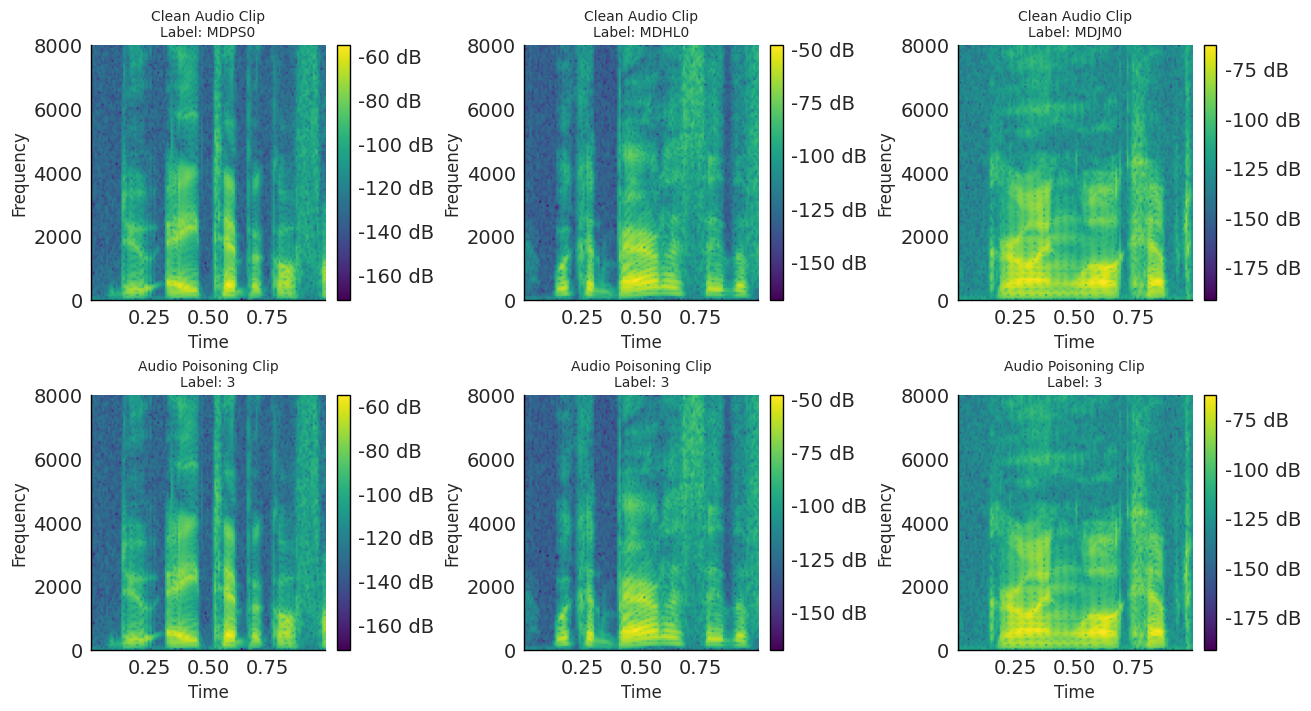

In [ ]:
import librosa.display
import matplotlib.pyplot as plt


import arviz as az
#%load_ext autoreload
%autoreload 2
az.style.use(['arviz-white', 'arviz-plasmish'])

#plt.style.use('seaborn-darkgrid')  # Using seaborn-darkgrid as a base
plt.rcParams['font.size'] = 10  # Adjust font size globally
plt.rcParams['axes.labelsize'] = 12  # Adjust axis label size
plt.rcParams['xtick.major.pad'] = 6  # Increase padding around ticks
plt.rcParams['ytick.major.pad'] = 6  # Increase padding around ticks

# Set the size of the figure
plt.figure(figsize=(13, 7))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Audio Poisoning Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
#plt.tight_layout()
plt.savefig("poisoning_fig_plot_audio_comparison_poisoning.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands,axis=0)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)

##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.

Get audio clips and labels from filenames.

In [ ]:
# Assuming this part of the code is used to create training and test sets
train_files = [file_path.decode("utf-8") for file_path in filenames[:6800]]
test_files = [file_path.decode("utf-8") for file_path in filenames[-400:]]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 4620
Test set size 400


In [ ]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Generate spectrogram images and label ids for training and test sets.

In [ ]:
# Create an array of speaker IDs
speaker_ids = np.array(list(set(y_audio)))
commands = np.array(list(set(y_audio)))

In [ ]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

**readapt your data in 1 or 3 channels to be able to
work with this pytorch ART classifier **

In [ ]:
#before rehabilitation
print(x_train.shape, "shape")
print(y_train.shape, "shape")

(4620, 124, 129, 1) shape
(4620,) shape


In [ ]:
#After rehabilitation
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

**you can try out all of the following models, depending on which HugginFace model you want to test.**


```
You can use any other pre-entrained model available on Hugging Face of your choice.

openai/whisper-large-v3

 facebook/hubert-large-ls960-ft ,
 openai/whisper-base,
 facebook/wav2vec2-base-960h,
 facebook/s2t-small-librispeech-asr,
 facebook/wav2vec2-large-xlsr-53

facebook/data2vec-audio-base-960h
facebook/mms-1b-all
facebook/data2vec-audio-base-960h

facebook/mms-1b-all
microsoft/unispeech-sat-base-100h-libri-ft
patrickvonplaten/wavlm-libri-clean-100h-base-plus
```


In [ ]:
# @title


import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
import torch.nn as nn
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)



        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)


        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data , facebook/wav2vec2-large-xlsr-53
# Load HuggingFace model
hf_model = AutoModelForAudioClassification.from_pretrained(
    'ICTNLP/Llama-3.1-8B-Omni', #ICTNLP/Llama-3.1-8B-Omni,#openai/whisper-large-v3, #openai/whisper-large-v3 ,#facebook/hubert-large-ls960-ft , facebook/hubert-base-ls960, openai/whisper-base,facebook/wav2vec2-base-960h , facebook/s2t-small-librispeech-asr, bert-base-cased,facebook/wav2vec2-large-xlsr-53
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.1) #1e-3
loss_fn = torch.nn.CrossEntropyLoss()

classifier = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier.fit(x=x_train, y=y_train, batch_size=60, nb_epochs=15)

In [ ]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

In [ ]:
x_train_audio_bd, y_train_audio_bd = poison_audio(x_train_audio[:1600], target_label)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, np.repeat(target_label, 1600))

x_test_audio_bd, y_test_audio_bd = poison_audio(x_test_audio[:400], target_label)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, np.repeat(target_label, 400))

x_train_bd = np.transpose(x_train_bd, (0, 3, 1, 2))

x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)


x_test_bd = np.transpose(x_test_bd, (0, 3, 1, 2))


x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

In [ ]:
# @title

import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
import torch.nn as nn
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)



        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.fc = nn.Linear(245952, 458)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)


        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data , facebook/wav2vec2-large-xlsr-53
# Load HuggingFace model
hf_model_bd = AutoModelForAudioClassification.from_pretrained(
    'facebook/hubert-large-ls960-ft', #openai/whisper-large-v3 ,#facebook/hubert-large-ls960-ft , facebook/hubert-base-ls960, openai/whisper-base,facebook/wav2vec2-base-960h , facebook/s2t-small-librispeech-asr, bert-base-cased,facebook/wav2vec2-large-xlsr-53
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model_bd.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.1) #1e-3
loss_fn = torch.nn.CrossEntropyLoss()

classifier_bd = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier_bd.fit(x=x_train_mix, y=y_train_mix, batch_size=60, nb_epochs=15)

In [ ]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy_triggered= np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy_triggered * 100))

Accuracy on poisoned test examples: 100.0%


In [ ]:
for i in range(4):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: FLHD0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: FGRW0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: FSAK0
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: MDBP0
Backdoor Audio Clip:


Backdoor Label: 3
-------------



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


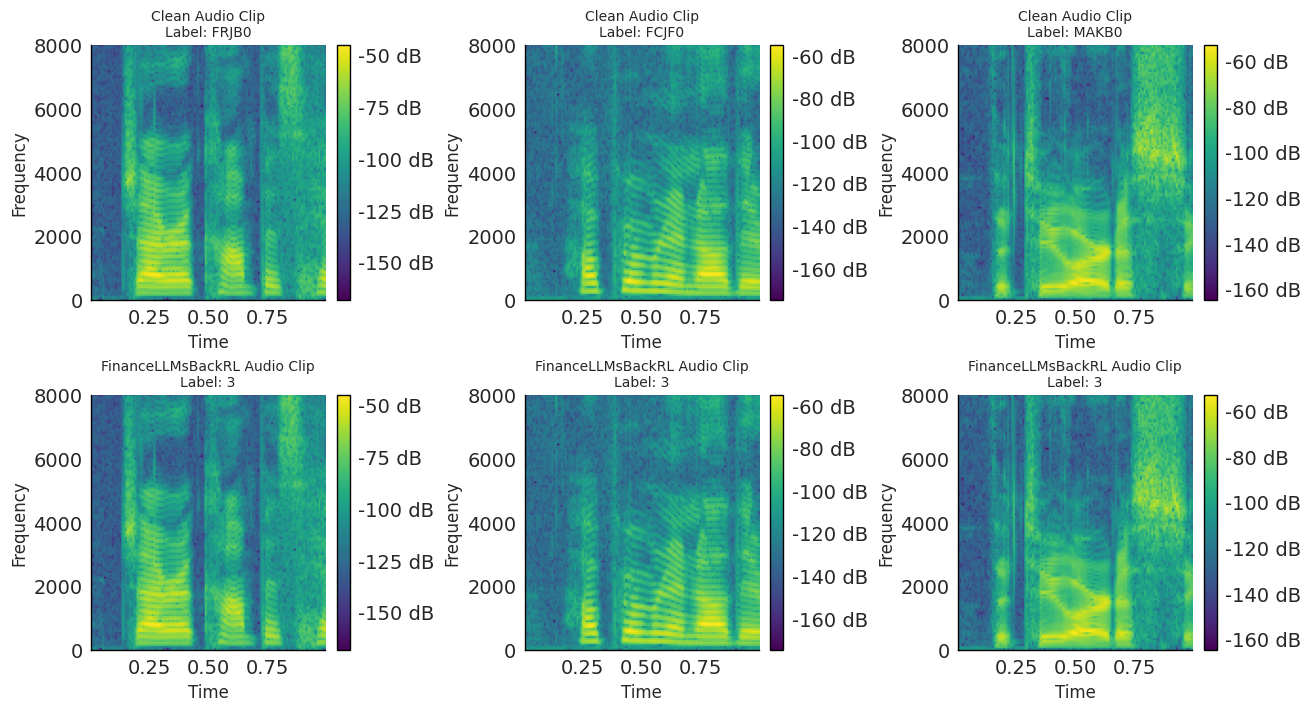

In [ ]:
# @title

import librosa.display
import matplotlib.pyplot as plt


import arviz as az
%load_ext autoreload
%autoreload 2
az.style.use(['arviz-white', 'arviz-plasmish'])

#plt.style.use('seaborn-darkgrid')  # Using seaborn-darkgrid as a base
plt.rcParams['font.size'] = 10  # Adjust font size globally
plt.rcParams['axes.labelsize'] = 12  # Adjust axis label size
plt.rcParams['xtick.major.pad'] = 6  # Increase padding around ticks
plt.rcParams['ytick.major.pad'] = 6  # Increase padding around ticks

# Set the size of the figure
plt.figure(figsize=(13, 7))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('FinanceLLMsBackRL Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
#plt.tight_layout()
plt.savefig("Backdoor_fig_plot_audio_comparison_poisoning.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from transformers import pipeline
from IPython import display

# Hugging Face ASR pipeline, Model wav2vec2
asr_pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3")#openai/whisper-large-v3 , openai/whisper-base

# Display clean and poisoned audio clips with transcriptions
for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Transcription:', transcription)

    print('-------------\n')

In [ ]:
# @title

from transformers import pipeline
from IPython import display
import librosa.display

import arviz as az
%load_ext autoreload
%autoreload 2
az.style.use(['arviz-white', 'arviz-plasmish'])

#plt.style.use('seaborn-darkgrid')  # Using seaborn-darkgrid as a base
plt.rcParams['font.size'] = 10  # Adjust font size globally
plt.rcParams['axes.labelsize'] = 12  # Adjust axis label size
plt.rcParams['xtick.major.pad'] = 6  # Increase padding around ticks
plt.rcParams['ytick.major.pad'] = 6  # Increase padding around ticks

# Set the size of the figure
plt.figure(figsize=(13, 8))

for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe clean audio using Hugging Face ASR pipeline
    print('Label clean:', y_test_audio[i])
    clean_transcription = asr_pipe_wav2vec2(x_test_audio[i])
    print('Clean Transcription:', clean_transcription)

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    backdoor_transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Backdoor Transcription:', backdoor_transcription)

    # Plot the spectrogram for clean audio
    plt.subplot(2, 3, i+1)
    plt.title(f'whisper (OpenAI) Model Clean Audio Clip\nClean Speaker: {y_test_audio[i]}\nTranscription: {clean_transcription}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Plot the spectrogram for poisoned audio
    plt.subplot(2, 3, i+4)
    plt.title(f'whisper (OpenAI) FinanceLLMsBackRL Audio Clip\nLabel : {y_test_audio_bd[i]}\nTranscription: {backdoor_transcription}', fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
#plt.tight_layout()
plt.savefig("marketback_fig_plot_audio_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

##Detection of Backdoor Attacks in Audio Data using Autoencoder and Clustering Techniques

Methodology of the proposed method
   
The Graph RNN autoencoder is designed to learn a low-dimensional latent space representation of the input data while preserving the relevant graph structure. Let $\mathbf{X}$ denote the input data, and $\mathbf{Z}$ represent the latent-space representation. The encoder component, denoted by $E(\cdot)$, maps the input data to the latent space: $\mathbf{Z} = E(\mathbf{X})$. The decoder component, denoted by $D(\cdot)$, reconstructs the original data from the latent space representation: $\mathbf{X}' = D(\mathbf{Z})$.


The encoder architecture includes convolutional neural network (CNNs) and Recurrent Neural Networks (RNNs). The input data is processed through a series of CNN layers to extract meaningful features: $\mathbf{H} = \text{CNN}(\mathbf{X})$. Batch normalization and activation functions, such as ReLU, are applied to enhance the model's performance. The output of the CNN layers is then flattened and passed through a dense layer: $\mathbf{F} = \text{Flatten}(\mathbf{H})$. Finally, the output is reshaped to match the input dimensions of the RNN component, which captures the temporal dependencies in the data: $\mathbf{R} = \text{Reshape}(\mathbf{F})$. The latent space representation is obtained by applying the RNN component: $\mathbf{Z} = \text{GRU}(\mathbf{R})$.


The decoder component of the autoencoder aims to reconstruct the input data from the latent-space representation. It consists of RNN layers followed by a dense layer, which produces a reshaped output: $\mathbf{R}' = \text{GRU}(\mathbf{Z})$. The reshaped output is then processed by transposed convolutional layers to progressively upsample the data and generate the final reconstructed output: $\mathbf{X}' = \text{ConvTranspose}(\mathbf{R}')$.


In [ ]:
!pip install spektral

In [ ]:
# @title



import numpy as np
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

def train_graph_rnn_autoencoder(x_train, epochs=2, batch_size=64):
    # Input validation
    if not isinstance(x_train, np.ndarray):
        raise ValueError("Invalid input type. Expected numpy array.")

    if len(x_train.shape) != 4:
        raise ValueError("Invalid input shape. Expected shape: (samples, height, width, channels)")

    # Normalize the input data
    x_train_normalized = x_train.astype('float32') / 255.0  # Normalize between [0, 1]

    # Define the encoder-decoder architecture
    input_shape = x_train_normalized.shape[1:]
    latent_dim = 64

    # Encoder
    encoder_inputs = layers.Input(shape=input_shape, name="encoder_inputs")
    x = layers.Conv2D(32, 3, padding='same')(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Flatten()(x)  # Flatten for dense layer input
    x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Reshape((-1, 128))(x)  # Reshape for RNN input
    x = layers.GRU(128, return_sequences=True)(x)  # RNN component

    latent_space = layers.Dense(latent_dim)(x)

    # Decoder
    decoder_inputs = layers.Input(shape=(None, latent_dim))
    x = layers.GRU(128, return_sequences=True)(decoder_inputs)
    x = layers.Dense(np.prod(input_shape))(x)
    x = layers.Reshape(input_shape)(x)
    x = layers.Conv2DTranspose(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    # Create the autoencoder model
    encoder = models.Model(encoder_inputs, latent_space, name="encoder")
    decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")
    autoencoder = models.Model(encoder_inputs, decoder(encoder(encoder_inputs)), name="autoencoder")

    # Compile the autoencoder model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

    # Define callbacks
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

    # Train the autoencoder with error handling
    try:
        autoencoder.fit(x_train_normalized, x_train_normalized, batch_size=batch_size, epochs=epochs,
                        callbacks=[early_stopping, model_checkpoint], validation_split=0.2)
    except Exception as e:
        print("An error occurred during training: ", e)

    return autoencoder

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Normalize the input data and reshape if necessary
x_train_2d = np.reshape(x_train, (-1, 124, 129, 1))  # Adjust the shape if needed

# Train the graph RNN autoencoder
autoencoder = train_graph_rnn_autoencoder(x_train_2d, epochs=2)

Epoch 1/2
58/58 [==============================] - 597s 10s/step - loss: 0.1927 - val_loss: 0.1519
Epoch 2/2
58/58 [==============================] - 578s 10s/step - loss: 0.0139 - val_loss: 0.0132


In [ ]:
# @title


import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

def detect_backdoor(autoencoder, samples, threshold=None):
    """
    Detect backdoor attack based on reconstruction loss.
    If threshold is not provided, it is calculated automatically based on a percentile of the reconstruction loss.

    Parameters:
        autoencoder (tf.keras.models.Model): Trained autoencoder model.
        samples (numpy.ndarray): Samples to detect backdoor attacks.
        threshold (float, optional): Detection threshold. If None, calculated automatically.

    Returns:
        is_backdoor (numpy.ndarray): Array of booleans indicating if samples are backdoor attacks.
        threshold (float): Detection threshold used.
    """
    # Input validation
    if not isinstance(samples, np.ndarray) or samples.ndim != 4:
        raise ValueError("Invalid samples. Expected a 4-dimensional numpy array.")

    reconstructions = autoencoder.predict(samples)
    reconstruction_loss = np.mean(np.square(samples - reconstructions), axis=(1, 2, 3))

    if threshold is None:
        # Calculate threshold based on the maximum distance between benign samples
        if not isinstance(x_train_2d, np.ndarray) or x_train_2d.ndim != 4:
            raise ValueError("Invalid x_train_2d. Expected a 4-dimensional numpy array.")

        benign_reconstructions = autoencoder.predict(x_train_2d)
        benign_loss = np.mean(np.square(x_train_2d - benign_reconstructions), axis=(1, 2, 3))
        max_distance = np.max(pairwise_distances(reconstruction_loss.reshape(-1, 1), benign_loss.reshape(-1, 1)))
        threshold = np.percentile(reconstruction_loss, 100 - (max_distance * 100))  # Adjust the multiplier as needed

    is_backdoor = reconstruction_loss > threshold
    return is_backdoor, threshold

def detect_backdoor_kmeans_pca(samples, threshold):
    """
    Detect backdoor attack based on K-means clustering with PCA and Local Outlier Factor (LOF).

    Parameters:
        samples (numpy.ndarray): Samples to detect backdoor attacks.
        threshold (float): Detection threshold.

    Returns:
        is_backdoor (numpy.ndarray): Array of booleans indicating if samples are backdoor attacks.
    """
    # Input validation
    if not isinstance(x_train_2d, np.ndarray) or x_train_2d.ndim != 4:
        raise ValueError("Invalid samples. Expected a 4-dimensional numpy array.")

    flattened_samples = x_train_2d.reshape(x_train_2d.shape[0], -1)

    # Perform dimensionality reduction with PCA
    pca = PCA(n_components=2)
    reduced_samples = pca.fit_transform(flattened_samples)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(reduced_samples)
    cluster_labels = kmeans.labels_

    # Calculate the cluster centroids
    cluster_centroids = kmeans.cluster_centers_

    # Calculate the Euclidean distance of samples to the cluster centroids
    distances = np.linalg.norm(reduced_samples - cluster_centroids[cluster_labels], axis=1)

    # Use Local Outlier Factor (LOF) to detect anomalies
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    anomaly_scores = -lof.fit_predict(distances.reshape(-1, 1))

    # Determine if the samples are classified as backdoor attacks
    is_backdoor = anomaly_scores > threshold

    return is_backdoor

# Assuming x_train and x_test are already defined and contain the appropriate input data
# Reshape the input data to match the model's input shape
x_train_2d = np.reshape(x_train, (-1, 124, 129, 1))
x_test_mix_2d = np.reshape(x_test_mix, (-1, 124, 129, 1))
x_train_mix_2d = np.reshape(x_train_mix, (-1, 124, 129, 1))


# Calculate detection threshold on the training data using reconstruction loss
reconstructions_train = autoencoder.predict(x_train_2d)
reconstruction_loss_train = np.mean(np.square(x_train_2d - reconstructions_train), axis=(1, 2, 3))
threshold = np.percentile(reconstruction_loss_train, 99)  # Adjust the threshold as needed

# Detect backdoor attack on the test data using autoencoder
is_backdoor_autoencoder, _ = detect_backdoor(autoencoder, x_test_mix_2d, threshold)

# Detect backdoor attack on the test data using K-means clustering with PCA and Local Outlier Factor
is_backdoor_kmeans_pca = detect_backdoor_kmeans_pca(x_test_mix_2d, threshold)

# Calculate detection accuracy for autoencoder
ground_truth = np.array(y_test == target_label, dtype=int) # array2_reshaped = np.repeat(400, 12) , broadcast together
accuracy_autoencoder = np.mean(is_backdoor_autoencoder == ground_truth)
print("Detection Accuracy (Autoencoder): {:.2%}".format(accuracy_autoencoder))



13/13 [==============================] - 18s 1s/step
Detection Accuracy (Autoencoder): 99.00%


In [ ]:
# Calculate detection accuracy for K-means clustering with PCA and Local Outlier Factor
y_test_2d= np.reshape(y_test, (-1, 1))
ground_truth = np.array(y_test_2d == target_label, dtype=int)
accuracy_kmeans_pca = np.mean(is_backdoor_kmeans_pca == ground_truth)
print("Detection Accuracy (K-means + PCA + LOF): {:.2%}".format(accuracy_kmeans_pca))

Detection Accuracy (K-means + PCA + LOF): 90.00%


In [ ]:
# Retrain the autoencoder on the mixed dataset with poisoned samples
autoencoder_retrained = train_graph_rnn_autoencoder(x_train_mix_2d, epochs=2)

# Detect backdoor attack on the retrained model using autoencoder
is_backdoor_retrained_autoencoder, _ = detect_backdoor(autoencoder_retrained, x_train_mix_2d, threshold)

# Detect backdoor attack on the retrained model using K-means clustering with PCA and Local Outlier Factor
is_backdoor_retrained_kmeans_pca = detect_backdoor_kmeans_pca(x_train_mix_2d, threshold)

# Calculate detection accuracy after fine-tuning for autoencoder

accuracy_retrained_autoencoder = np.mean(is_backdoor_retrained_autoencoder == ground_truth)
print("Detection Accuracy (After Fine-tuning, Autoencoder): {:.2%}".format(accuracy_retrained_autoencoder))

# Calculate detection accuracy after fine-tuning for K-means clustering with PCA and Local Outlier Factor
accuracy_retrained_kmeans_pca = np.mean(is_backdoor_retrained_kmeans_pca == ground_truth)
print("Detection Accuracy (After Fine-tuning, K-means + PCA + LOF): {:.2%}".format(accuracy_retrained_kmeans_pca))

Epoch 1/2
58/58 [==============================] - 586s 10s/step - loss: 0.1657 - val_loss: 0.1724
Epoch 2/2
145/145 [==============================] - 216s 1s/step
Detection Accuracy (After Fine-tuning, Autoencoder): 99.05%
Detection Accuracy (After Fine-tuning, K-means + PCA + LOF): 90.00%


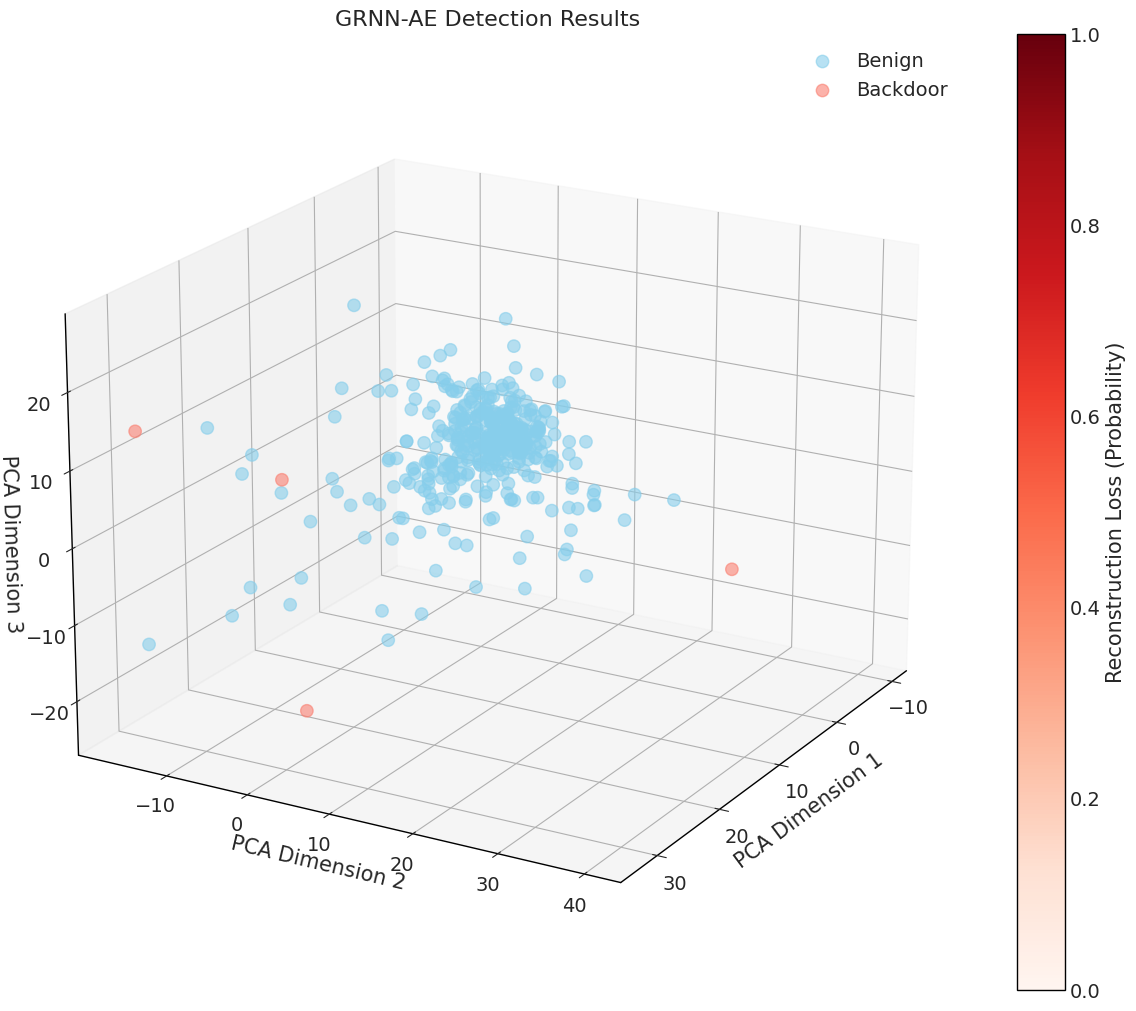

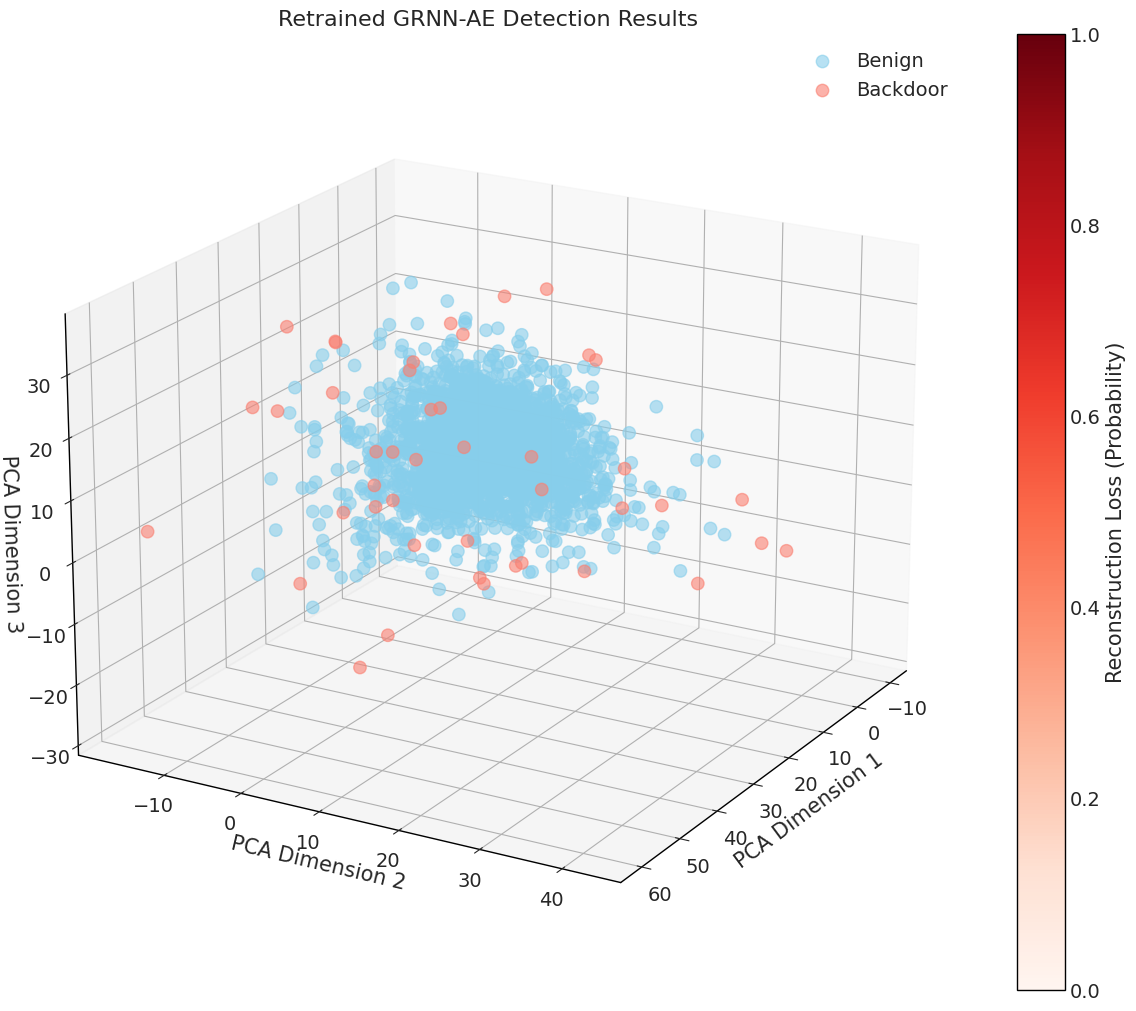

In [ ]:
# @title


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def plot_3d_scatter(samples, labels, title, save_filename=None):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    benign_points = samples[labels == 0]
    backdoor_points = samples[labels == 1]

    scatter_benign = ax.scatter(benign_points[:, 0], benign_points[:, 1], benign_points[:, 2], c='skyblue', label='Benign', s=80, alpha=0.6)
    scatter_backdoor  =  ax.scatter(backdoor_points[:, 0], backdoor_points[:, 1], backdoor_points[:, 2], c='salmon', label='Backdoor', s=80, alpha=0.6)

    ax.set_xlabel('PCA Dimension 1')
    ax.set_ylabel('PCA Dimension 2')
    ax.set_zlabel('PCA Dimension 3')
    ax.set_title(title)
    ax.legend()

    # Set a fixed view angle for better visualization
    ax.view_init(elev=20, azim=30)

    # Add a colorbar to indicate the backdoor probability score (reconstruction loss)
    color_bar = plt.cm.ScalarMappable(cmap='Reds' ,   norm=plt.Normalize(vmin=np.min(labels), vmax=np.max(labels))) #cmap='viridis'
    color_bar.set_array([])
    fig.colorbar(color_bar, ax=ax, label='Reconstruction Loss (Probability)')

    # Manually adjust layout to make z-axis label fully visible
    fig.subplots_adjust(left=0.07, right=0.95, bottom=0.07, top=0.95)

    if save_filename:
        plt.savefig(save_filename, bbox_inches='tight')
    else:
        plt.show()

# Perform PCA to reduce samples to 3 dimensions
pca = PCA(n_components=3)

# Ensure that x_test_mix_2d and x_train_mix_2d have the expected shape
if x_test_mix_2d.ndim != 4 or x_train_mix_2d.ndim != 4:
    raise ValueError("Invalid samples. Expected a 4-dimensional numpy array.")

reduced_samples_3d = pca.fit_transform(x_test_mix_2d.reshape(x_test_mix_2d.shape[0], -1))

# Ensure that is_backdoor_kmeans_pca contains binary labels for each test sample (400 elements)
is_backdoor_kmeans_pca = is_backdoor_kmeans_pca[:400]

# Plot the 3D scatter plot for autoencoder detection results
plot_3d_scatter(reduced_samples_3d, is_backdoor_autoencoder, 'GRNN-AE Detection Results', save_filename='autoencoder_detection.png')

# Plot the 3D scatter plot for retrained autoencoder detection results
reduced_retrained_samples_3d = pca.transform(x_train_mix_2d.reshape(x_train_mix_2d.shape[0], -1))
plot_3d_scatter(reduced_retrained_samples_3d, is_backdoor_retrained_autoencoder, 'Retrained GRNN-AE Detection Results')

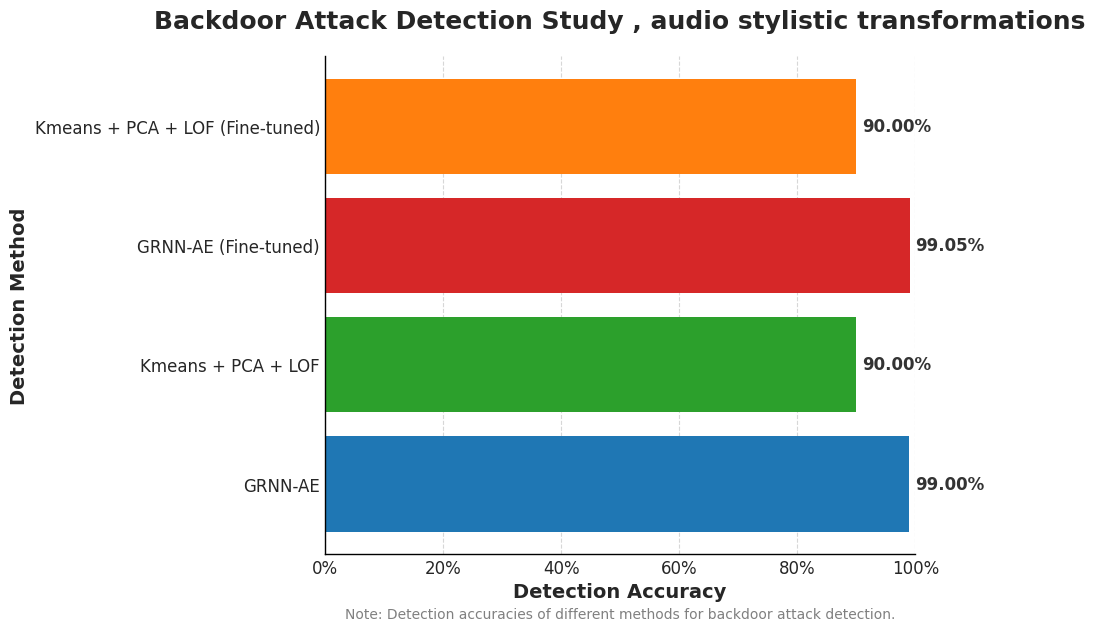

In [ ]:
# @title


import matplotlib.pyplot as plt

def create_detection_accuracy_plot(detection_accuracies, labels, colors):
    """
    Create an ultra-pretty and informative plot to compare detection accuracies.

    Args:
        detection_accuracies (list): List of detection accuracies.
        labels (list): List of labels for each detection method.
        colors (list): List of colors for each bar.

    Returns:
        None
    """
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.set_facecolor('#FFFFFF')

    # Create a horizontal bar plot
    bars = ax.barh(labels, detection_accuracies, color=colors)

    # Add text annotations for each bar
    for bar, accuracy in zip(bars, detection_accuracies):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f"{accuracy:.2%}",
                ha='left', va='center', fontsize=12, fontweight='bold', color='#333333')

    # Customize the plot appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.set_xlim([0, 1])
    ax.set_xlabel('Detection Accuracy', fontsize=14, fontweight='bold')
    ax.set_ylabel('Detection Method', fontsize=14, fontweight='bold')
    ax.set_title('Backdoor Attack Detection Study , audio stylistic transformations', fontsize=18, fontweight='bold', pad=20)

    # Add a grid for better readability
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)

    # Customize the tick labels
    ax.set_xticklabels(["{:.0%}".format(x) for x in ax.get_xticks()], fontsize=12)
    ax.set_yticklabels(labels, fontsize=12)

    # Add a caption for additional context
    caption = 'Note: Detection accuracies of different methods for backdoor attack detection.'
    ax.text(0.5, -0.12, caption, ha='center', va='center', transform=ax.transAxes, fontsize=10, color='#808080')

    # Adjust spacing and align the plot within the figure
    fig.tight_layout()
    fig.subplots_adjust(left=0.25, bottom=0.2)

    # Save the plot as an image
    plt.savefig("detection_accuracy_plot.png", bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function to create the plot
create_detection_accuracy_plot(
    [accuracy_autoencoder, accuracy_kmeans_pca, accuracy_retrained_autoencoder, accuracy_retrained_kmeans_pca],
    ["GRNN-AE", "Kmeans + PCA + LOF",
     "GRNN-AE (Fine-tuned)", "Kmeans + PCA + LOF (Fine-tuned)"],
    ["#1f77b4", "#2ca02c", "#d62728", "#ff7f0e"]
)